In [1]:
import sys
import math
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, utils
import torchvision
import torch.nn.functional as F
import torchvision.utils as vutils
from torch.nn.utils import spectral_norm
from torchmetrics.image.fid import FrechetInceptionDistance
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import random


from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device: ", device)

Device:  cuda


In [2]:
def show_imgs(x, newFig=True):
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0, 2).transpose(0, 1)
    if newFig:
        plt.figure()
    plt.imshow(grid.numpy())

In [17]:
# Simple Feedforward Neural Network for Discriminator
class Discriminator(nn.Module):
    def __init__(self, inputDimension=784):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(inputDimension, 128)
        self.nonLin1 = nn.LeakyReLU(0.1)
        self.nonLin2 = nn.LeakyReLU(0.1)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = x.view(x.size(0), 784)  # flatten
        h1 = self.nonLin1(self.fc1(x))
        h2 = self.nonLin2(h1)
        out = self.fc2(h2)
        out = torch.sigmoid(out)
        return out


class Generator(nn.Module):
    def __init__(self, zDimension=100):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(zDimension, 128)
        self.nonLin1 = nn.LeakyReLU(0.1)
        self.nonLin1 = nn.LeakyReLU(0.1)
        self.fc2 = nn.Linear(128, 784)

    def forward(self, x):
        h1 = self.nonLin1(self.fc1(x))
        h2 = self.nonLin1(h1)
        out = self.fc2(h2)
        out = torch.tanh(out)
        out = out.view(x.size(0), 1, 28, 28)
        return out

In [3]:
# DCGAN Architecture for Discriminator and Generator
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=1, feature_g=64):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # input Z: (batch, z_dim, 1, 1)
            nn.ConvTranspose2d(z_dim, feature_g * 4, 7, 1, 0),  # (batch, 256, 7, 7)
            nn.BatchNorm2d(feature_g * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                feature_g * 4, feature_g * 2, 4, 2, 1
            ),  # (batch, 128, 14, 14)
            nn.BatchNorm2d(feature_g * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                feature_g * 2, img_channels, 4, 2, 1
            ),  # (batch, 1, 28, 28)
            nn.Tanh(),
        )

    def forward(self, x):
        return self.gen(x)


class Discriminator(nn.Module):
    def __init__(self, img_channels=1, feature_d=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: (batch, 1, 28, 28)
            nn.Conv2d(img_channels, feature_d, 4, 2, 1),  # (batch, 64, 14, 14)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d, feature_d * 2, 4, 2, 1),  # (batch, 128, 7, 7)
            nn.BatchNorm2d(feature_d * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d * 2, 1, 7, 1, 0),  # (batch, 1, 1, 1)
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x).view(-1, 1)

In [5]:
D = Discriminator()
G = Generator()
print(D)
print(G)

Discriminator(
  (disc): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 1, kernel_size=(7, 7), stride=(1, 1))
    (6): Sigmoid()
  )
)
Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Tanh()
  )
)


In [37]:
samples = torch.randn(5, 1, 28, 28)  # batch size x channels x height x width
D(samples)  # calls the .forward() method implicitly

tensor([[0.4515],
        [0.4637],
        [0.4765],
        [0.6323],
        [0.5146]], grad_fn=<SigmoidBackward0>)


### Things to try:

- What happens if you change the number of samples in a batch?
    - Number of outputs are increased
- What happens if you change the width/height of the input?
    - We run into an error saying that input is not valid. If we generalize the `Discriminator` class, then also we cannot get proper output while adding non-linearty

In [52]:
# print weights from named_parameters
for name, param in D.named_parameters():
    # print(name, param.data)
    print(name, param.size())

fc1.weight torch.Size([128, 784])
fc1.bias torch.Size([128])
fc2.weight torch.Size([1, 128])
fc2.bias torch.Size([1])


In [53]:
z = torch.randn(2, 100)  # batch size x z dimension
xGen = G(z)
xGen.shape

torch.Size([2, 1, 28, 28])

In [ ]:
show_imgs(xGen)
show_imgs(z.view(z.size(0), 1, 10, 10))

In [12]:
dataset = torchvision.datasets.FashionMNIST(
    root="./FashionMNIST/",
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    ),
    download=True,
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

torch.Size([1, 28, 28])

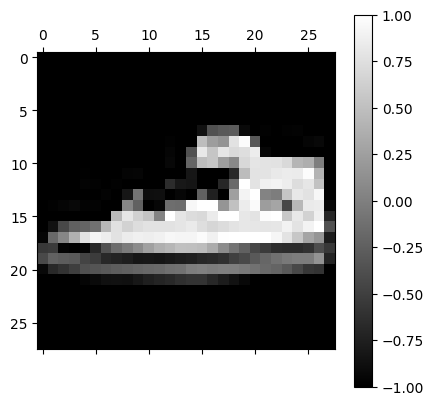

In [16]:
x, _ = dataset[153]
plt.matshow(x.squeeze().numpy(), cmap="gray")
plt.colorbar()
x.shape

In [69]:
Dscore = D(x)
Dscore.item()

0.47513547539711

In [ ]:
xbatch, _ = next(iter(dataloader))
Dscores = D(xbatch)
for image, score in zip(xbatch[:5], Dscores[:5]):
    plt.matshow(image.squeeze().numpy(), cmap="gray")
    plt.colorbar()
    plt.title(f"Score: {score.item():.4f}")

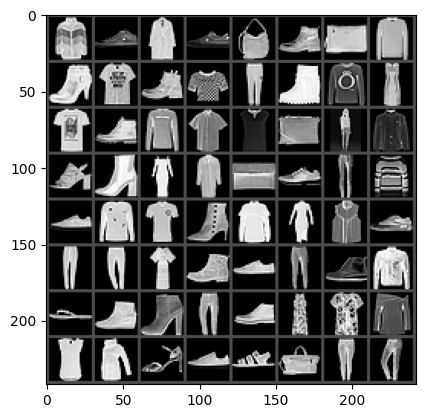

In [76]:
show_imgs(xbatch)

## AutoGrad example

In [91]:
torch.manual_seed(153)
x = torch.rand(2, 2, requires_grad=True)
x

tensor([[0.8112, 0.3310],
        [0.4712, 0.7664]], requires_grad=True)

In [92]:
print(x.grad)  # None

None


In [93]:
y = x**2 + x
z = y.sum()
z

tensor(3.9567, grad_fn=<SumBackward0>)

In [95]:
z.backward()
x.grad

tensor([[2.6223, 1.6621],
        [1.9424, 2.5327]])

In [96]:
2 * x + 1

tensor([[2.6223, 1.6621],
        [1.9424, 2.5327]], grad_fn=<AddBackward0>)

In [99]:
x1 = torch.Tensor([1, 2, 3, -3, -2])
y = torch.Tensor([3, 6, 9, -9, -6]).view(5, 1)
x2 = torch.randn(5)
x = torch.stack([x1, x2], dim=1)  # 5 x 2 input. 5 datapoints, 2 dimensions.
# theta = torch.randn(1,2, requires_grad=True) # ~equal to:
theta = torch.nn.Parameter(torch.randn(1, 2))
# we start theta at random initialization, the gradient will point us in the right direction.
print("x:\n", x)
print("y:\n", y)
print("theta at random initialization: ", theta)
thetatrace = [theta.data.clone()]  # initial value, for logging

x:
 tensor([[ 1.0000,  1.1894],
        [ 2.0000,  0.2688],
        [ 3.0000, -1.3762],
        [-3.0000,  1.1894],
        [-2.0000,  0.3248]])
y:
 tensor([[ 3.],
        [ 6.],
        [ 9.],
        [-9.],
        [-6.]])
theta at random initialization:  Parameter containing:
tensor([[-0.1433, -0.1926]], requires_grad=True)


In [168]:
ypred = x @ theta.t()  # matrix multiply; (N x 2) * (2 x 1) -> N x 1
print("ypred:\n", ypred)
loss = ((ypred - y) ** 2).mean()  # mean squared error = MSE
print("mse loss: ", loss.item())
loss.backward()
print("dL / d theta:\n", theta.grad)
# let's move W in that direction
theta.data.add_(-0.1 * theta.grad.data)
# Now we will reset the gradient to zero.
theta.grad.zero_()
print("theta:\n", theta)
thetatrace.append(theta.data.clone())  # for logging

ypred:
 tensor([[ 2.9998],
        [ 5.9999],
        [ 9.0001],
        [-9.0000],
        [-6.0000]], grad_fn=<MmBackward0>)
mse loss:  1.1769406782491387e-08
dL / d theta:
 tensor([[-4.5013e-05, -1.6395e-04]])
theta:
 Parameter containing:
tensor([[ 3.0000e+00, -1.1700e-04]], requires_grad=True)


In [169]:
torch.manual_seed(23801)
net = nn.Linear(2, 1, bias=False)
optimizer = torch.optim.SGD(
    net.parameters(), lr=0.1
)  # do updates with `optimizer.step()`
# x, y defined above. In a real problem we would typically get different x, y "minibatches"
# of samples from a dataloader.
for i in range(100):  # 10 optimization steps (gradient descent steps)
    ypred = net(x)
    loss = ((ypred - y) ** 2).mean()  # mean squared error = MSE
    optimizer.zero_grad()
    loss.backward()
    # and instead of W.data -= 0.1 * W.grad we do:
    optimizer.step()
print(net.weight)

Parameter containing:
tensor([[ 3.0000e+00, -7.0681e-07]], requires_grad=True)


In [6]:
D = Discriminator()
print(D)
G = Generator()
print(G)
# Now let's set up the optimizers
optimizerD = torch.optim.SGD(D.parameters(), lr=0.01)
optimizerG = torch.optim.SGD(G.parameters(), lr=0.01)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (nonLin1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)
Generator(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (nonLin1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=784, bias=True)
)


In [252]:
# STEP 1: Discriminator optimization step
x_real, _ = next(iter(dataloader))
lab_real = torch.ones(64, 1)
lab_fake = torch.zeros(64, 1)
# reset accumulated gradients from previous iteration
optimizerD.zero_grad()

D_x = D(x_real)
lossD_real = criterion(D_x, lab_real)

z = torch.randn(64, 100)  # random noise, 64 samples, z_dim=100
x_gen = G(z).detach()
D_G_z = D(x_gen)
lossD_fake = criterion(D_G_z, lab_fake)

lossD = lossD_real + lossD_fake
lossD.backward()
optimizerD.step()

print(D_x.mean().item(), D_G_z.mean().item())

0.9761868119239807 0.23800119757652283


In [291]:
# STEP 2: Generator optimization step
# note how only one of the terms involves the Generator so this is the only one that matters for G.
# reset accumulated gradients from previous iteration
optimizerG.zero_grad()

z = torch.randn(64, 100)  # random noise, 64 samples, z_dim=100
D_G_z = D(G(z))
lossG = criterion(D_G_z, lab_real)  # -log D(G(z))

lossG.backward()
optimizerG.step()

print(D_G_z.mean().item())

0.31000056862831116


Device:  cuda
e0.i0/938 last mb D(x)=0.4527 D(G(z))=0.4166
e0.i100/938 last mb D(x)=0.9880 D(G(z))=0.0006
e0.i200/938 last mb D(x)=0.9805 D(G(z))=0.0003
e0.i300/938 last mb D(x)=0.9982 D(G(z))=0.0026
e0.i400/938 last mb D(x)=0.9920 D(G(z))=0.0087
e0.i500/938 last mb D(x)=0.9986 D(G(z))=0.0010
e0.i600/938 last mb D(x)=0.9949 D(G(z))=0.0010
e0.i700/938 last mb D(x)=0.9963 D(G(z))=0.0000
e0.i800/938 last mb D(x)=0.9996 D(G(z))=0.0007
e0.i900/938 last mb D(x)=0.9991 D(G(z))=0.0005
e1.i0/938 last mb D(x)=0.9997 D(G(z))=0.0004
e1.i100/938 last mb D(x)=0.9998 D(G(z))=0.0004
e1.i200/938 last mb D(x)=0.9999 D(G(z))=0.0003
e1.i300/938 last mb D(x)=0.9999 D(G(z))=0.0008
e1.i400/938 last mb D(x)=0.9999 D(G(z))=0.0002
e1.i500/938 last mb D(x)=0.9999 D(G(z))=0.0001
e1.i600/938 last mb D(x)=0.9997 D(G(z))=0.0001
e1.i700/938 last mb D(x)=0.9996 D(G(z))=0.0001
e1.i800/938 last mb D(x)=1.0000 D(G(z))=0.0001
e1.i900/938 last mb D(x)=1.0000 D(G(z))=0.0001
e2.i0/938 last mb D(x)=0.9999 D(G(z))=0.0001
e2.i1

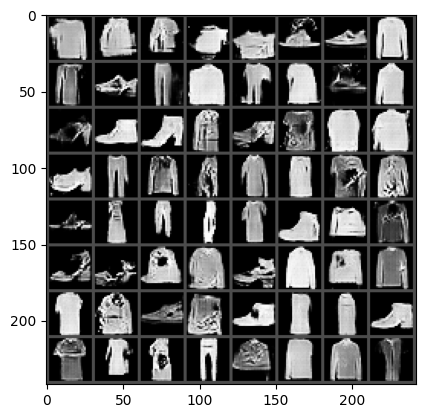

In [ ]:
# and the BCE criterion which computes the loss above:
criterion = nn.BCELoss()

D = Discriminator().to(device)
G = Generator(z_dim=z_dim).to(device)
# Now let's set up the optimizers (Adam, better than SGD for this)
# optimizerD = torch.optim.SGD(D.parameters(), lr=0.03)
# optimizerG = torch.optim.SGD(G.parameters(), lr=0.03)
optimizerD = torch.optim.Adam(D.parameters(), lr=0.0002)
optimizerG = torch.optim.Adam(G.parameters(), lr=0.0002)

# for plotting
losses_G = []
losses_D = []
scores_real = []
scores_fake = []


# for logging:
collect_x_gen = []
# fixed_noise = torch.randn(64, 100, device=device) # for simple model
fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)  # for DCGAN
fig = plt.figure()  # keep updating this one
plt.ion()

for epoch in range(20):  # 3 epochs
    for i, data in enumerate(dataloader, 0):
        # STEP 1: Discriminator optimization step
        x_real, _ = next(iter(dataloader))
        x_real = x_real.to(device)
        batch_size = x_real.size(0)

        # dynamic labels
        lab_real = torch.ones(batch_size, 1, device=device)
        lab_fake = torch.zeros(batch_size, 1, device=device)

        # reset accumulated gradients from previous iteration
        optimizerD.zero_grad()

        D_x = D(x_real)
        lossD_real = criterion(D_x, lab_real)

        # z = torch.randn(64, 100, device=device)  # random noise, 64 samples, z_dim=100 for simple model
        z = torch.randn(
            batch_size, z_dim, 1, 1, device=device
        )  # random noise, 64 samples, z_dim=100 for DCGAN
        x_gen = G(z).detach()
        D_G_z = D(x_gen)
        lossD_fake = criterion(D_G_z, lab_fake)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        # STEP 2: Generator optimization step
        # reset accumulated gradients from previous iteration
        optimizerG.zero_grad()

        # z = torch.randn(64, 100, device=device)  # random noise, 64 samples, z_dim=100 for simple model
        z = torch.randn(
            batch_size, z_dim, 1, 1, device=device
        )  # random noise, 64 samples, z_dim=100 for DCGAN
        x_gen = G(z)
        D_G_z = D(x_gen)
        lossG = criterion(D_G_z, lab_real)  # -log D(G(z))

        lossG.backward()
        optimizerG.step()

        losses_G.append(lossG.item())
        losses_D.append(lossD.item())
        scores_real.append(D_x.mean().item())
        scores_fake.append(D_G_z.mean().item())
        if i % 100 == 0:
            x_gen = G(fixed_noise)
            show_imgs(x_gen, newFig=False)
            fig.canvas.draw()
            print(
                "e{}.i{}/{} last mb D(x)={:.4f} D(G(z))={:.4f}".format(
                    epoch, i, len(dataloader), D_x.mean().item(), D_G_z.mean().item()
                )
            )
    # End of epoch
    x_gen = G(fixed_noise)
    collect_x_gen.append(x_gen.detach().clone())

In [ ]:
for xGen in collect_x_gen:
    show_imgs(xGen)

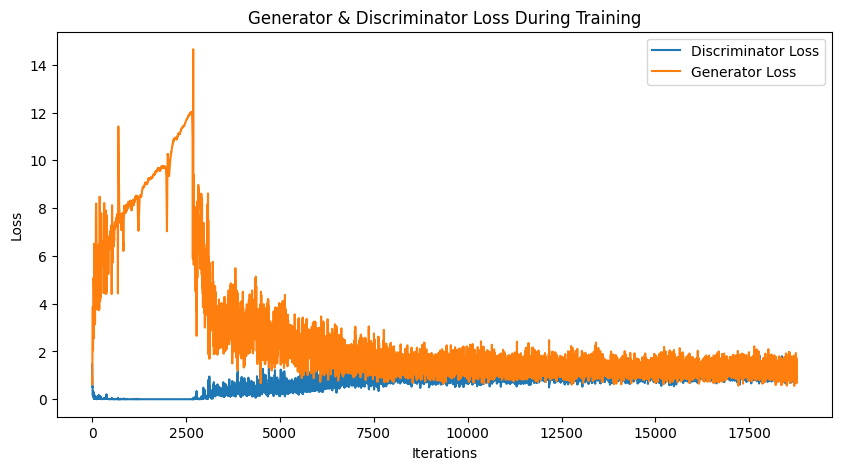

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(losses_D, label="Discriminator Loss")
plt.plot(losses_G, label="Generator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.title("Generator & Discriminator Loss During Training")
plt.show()

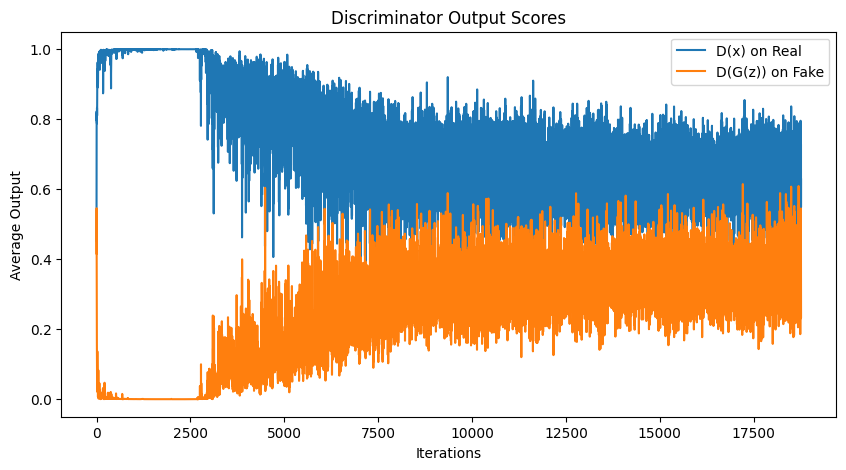

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(scores_real, label="D(x) on Real")
plt.plot(scores_fake, label="D(G(z)) on Fake")
plt.xlabel("Iterations")
plt.ylabel("Average Output")
plt.legend()
plt.title("Discriminator Output Scores")
plt.show()

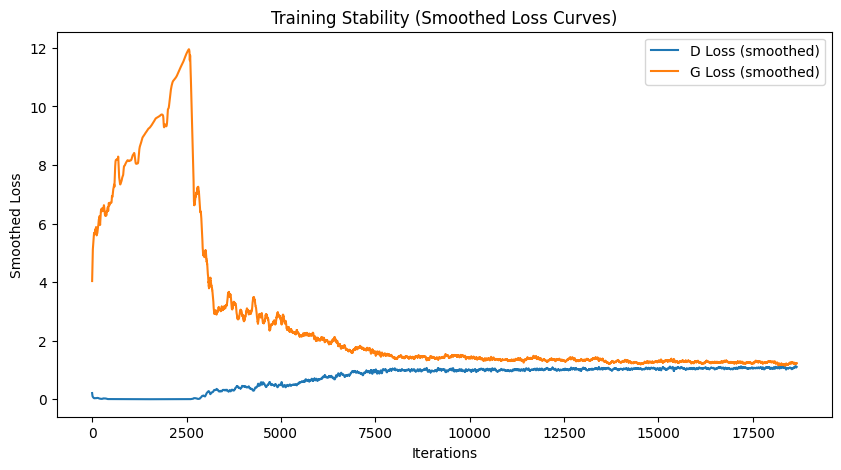

In [ ]:


def moving_average(x, window=100):
    return np.convolve(x, np.ones(window) / window, mode="valid")


plt.figure(figsize=(10, 5))
plt.plot(moving_average(losses_D), label="D Loss (smoothed)")
plt.plot(moving_average(losses_G), label="G Loss (smoothed)")
plt.xlabel("Iterations")
plt.ylabel("Smoothed Loss")
plt.legend()
plt.title("Training Stability (Smoothed Loss Curves)")
plt.show()

In [ ]:
# for MNIST/FashionMNIST
def preprocess_for_fid(imgs: torch.Tensor) -> torch.Tensor:
    """
    Convert FashionMNIST images from [-1,1], shape (N,1,28,28)
    → uint8 [0,255], shape (N,3,28,28) for FID.
    """
    # From [-1,1] → [0,1]
    imgs = (imgs + 1) / 2.0

    # Scale to [0,255]
    imgs = (imgs * 255).clamp(0, 255).to(torch.uint8)

    # Repeat grayscale channel to RGB
    imgs = imgs.repeat(1, 3, 1, 1)

    return imgs

In [26]:
fid = FrechetInceptionDistance(feature=2048).to(device)

# Real images
for real_imgs, _ in dataloader:
    real_imgs = real_imgs.to(device)
    real_uint8 = preprocess_for_fid(real_imgs)
    fid.update(real_uint8, real=True)

# Fake images
num_fake = 1000
batch_size = 64
for _ in range(num_fake // batch_size):
    z = torch.randn(batch_size, z_dim, 1, 1, device=device)
    fake_imgs = G(z)
    fake_uint8 = preprocess_for_fid(fake_imgs)
    fid.update(fake_uint8, real=False)

print("FID score:", fid.compute().item())

FID score: 370.184326171875


In [25]:
# create directory if it doesn't exist
directory = "savedModels/DCGAN_KPT_TIPS_RGB"
if not os.path.exists(directory):
    os.makedirs(directory)

# Save checkpoint
torch.save(
    {
        "epoch": epoch,
        "generator_state_dict": G.state_dict(),
        "discriminator_state_dict": D.state_dict(),
        "optimizerG_state_dict": optimizerG.state_dict(),
        "optimizerD_state_dict": optimizerD.state_dict(),
        "lossG": lossG,
        "lossD": lossD,
    },
    f"{directory}/checkpoint[21-40].pth",
)

In [ ]:
# save models
torch.save(G.state_dict(), "savedModels/DCGAN_KPT_TIPS_RGB/generator.pth")
torch.save(D.state_dict(), "savedModels/DCGAN_KPT_TIPS_RGB/discriminator.pth")

In [ ]:
# load models
G = Generator(z_dim=z_dim).to(device)
D = Discriminator().to(device)

G.load_state_dict(
    torch.load("savedModels/DCGAN_MNIST/generator.pth", map_location=device)
)
D.load_state_dict(
    torch.load("savedModels/DCGAN_MNIST/discriminator.pth", map_location=device)
)

In [3]:
dataset = torchvision.datasets.ImageFolder(
    root="KTH-TIPS/KTH-TIPS2-b",
    # transformation for RGB images (old model)
    # transform=transforms.Compose(
    #     [
    #         transforms.Resize((200, 200)),
    #         transforms.ToTensor(),
    #         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # 3 channels
    #     ]
    # transformation for grayscale images
    # transform=transforms.Compose(
    #     [
    #         transforms.Grayscale(num_output_channels=1),
    #         transforms.Resize((200, 200)),
    #         transforms.ToTensor(),
    #         transforms.Normalize((0.5,), (0.5,)),
    #     ]
    # data augmentation for enhanced DCGAN model
    transform=transforms.Compose(
        [
            transforms.Resize((200, 200)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
            transforms.ToTensor(),
            transforms.Normalize([0.5] * 3, [0.5] * 3),
        ]
    ),
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

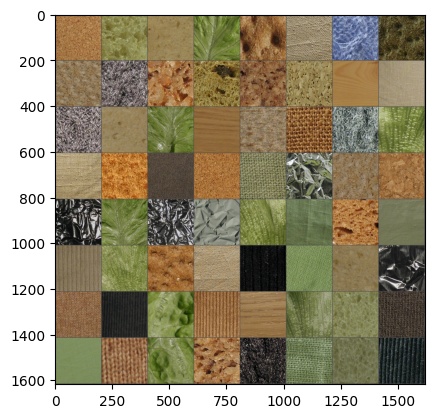

In [4]:
real_imgs, _ = next(iter(dataloader))
show_imgs(real_imgs)

In [5]:
# DCGAN for KTH-TIPS
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=1, feature_g=64):
        super(Generator, self).__init__()

        self.gen = nn.Sequential(
            # Input: (B, z_dim, 1, 1)
            nn.ConvTranspose2d(
                in_channels=z_dim,
                out_channels=feature_g * 16,
                kernel_size=5,
                stride=1,
                padding=0,
                bias=False,
            ),  # (B, 1024, 5, 5)
            nn.BatchNorm2d(feature_g * 16),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(
                in_channels=feature_g * 16,
                out_channels=feature_g * 8,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),  # (B, 512, 10, 10)
            nn.BatchNorm2d(feature_g * 8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(
                in_channels=feature_g * 8,
                out_channels=feature_g * 4,
                kernel_size=5,
                stride=2,
                padding=2,
                bias=False,
            ),  # (B, 256, 25, 25)
            nn.BatchNorm2d(feature_g * 4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(
                in_channels=feature_g * 4,
                out_channels=feature_g * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),  # (B, 128, 50, 50)
            nn.BatchNorm2d(feature_g * 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(
                in_channels=feature_g * 2,
                out_channels=feature_g,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),  # (B, 64, 100, 100)
            nn.BatchNorm2d(feature_g),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(
                in_channels=feature_g,
                out_channels=img_channels,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),  # ~ (B, 1, ~200, ~200)
            # <-- Fix to guarantee exact 200x200 output
            nn.Upsample(size=(200, 200), mode="bilinear", align_corners=False),
            nn.Tanh(),
        )

    def forward(self, z):
        return self.gen(z)


class Discriminator(nn.Module):
    def __init__(self, img_channels=1, feature_d=64):
        super(Discriminator, self).__init__()

        self.disc = nn.Sequential(
            # Input: (B, 1, 200, 200)
            nn.Conv2d(img_channels, feature_d, 4, 2, 1, bias=False),  # (64, 100, 100)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d, feature_d * 2, 4, 2, 1, bias=False),  # (128, 50, 50)
            nn.BatchNorm2d(feature_d * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                feature_d * 2, feature_d * 4, 4, 2, 1, bias=False
            ),  # (256, 25, 25)
            nn.BatchNorm2d(feature_d * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                feature_d * 4, feature_d * 8, 4, 2, 1, bias=False
            ),  # (512, 12, 12)
            nn.BatchNorm2d(feature_d * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                feature_d * 8, feature_d * 16, 4, 2, 1, bias=False
            ),  # (1024, 6, 6)
            nn.BatchNorm2d(feature_d * 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d * 16, 1, 6, 1, 0, bias=False),  # (1, 1, 1)
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x).view(-1, 1)

# What changes did we make?
- Changed loss function from BCE to Hinge loss.
    - Hinge loss + raw logits is widely used in modern GANs (BigGAN). Gives stronger gradients to generator when discriminator is confident. (removed final sigmoid layer in D)

- Adding Spectral Normalization on Discriminator
    - Controls Lopschitz constant of D --> Stabilizes training and prevents D from becoming too strong.

- Changed ConvTranspose 2D to Upsample followed by Conv
    - ConvTranspose was causing checkerboard artifacts. The changed layers are expected to produce smoother outputs.

- Minibatch StdDev layer in D
    - This way, D detects lack of diversity / mode collapse, in turn encourages G to produce diverse results.

- Adding variations to dataset
    - Random horizontal flips (50%), color Jitter (10% chance to change saturation, brightness and contrast)

A function is Lipschitz continuous if it follows:

`|f(x1) - f(x2)| <= K|x1 - x2|`

Interpretation --> The output of f can't change faster than K times the change in input.

By controlling this Lipschitz constant, we are <b> forcing linear and conv layer in D to have limited slope (<=1), which prevents exploding gradients and unstable training.

In [5]:
# Enhanced DCGAN for KTH-TIPS RGB
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3, feature_g=64):
        super().__init__()
        self.init_size = 5  # Starting feature map size (after dense projection)
        self.fc = nn.Linear(z_dim, feature_g * 16 * self.init_size * self.init_size)

        def block(in_ch, out_ch):
            return nn.Sequential(
                nn.Upsample(scale_factor=2, mode="nearest"),
                nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(True),
            )

        self.net = nn.Sequential(
            block(feature_g * 16, feature_g * 8),  # 5 -> 10
            block(feature_g * 8, feature_g * 4),  # 10 -> 20
            block(feature_g * 4, feature_g * 2),  # 20 -> 40
            block(feature_g * 2, feature_g),  # 40 -> 80
            block(feature_g, feature_g // 2),  # 80 -> 160
            nn.Upsample(size=(200, 200), mode="bilinear", align_corners=False),
            nn.Conv2d(feature_g // 2, img_channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.fc(z).view(z.size(0), -1, self.init_size, self.init_size)
        return self.net(out)


def minibatch_stddev(x, group_size=4):
    B, C, H, W = x.shape
    G = min(group_size, B)
    y = x.view(G, -1, C, H, W)
    std = y.std(0, unbiased=False).mean(dim=1, keepdim=True)
    std = std.repeat(G, 1, 1, 1, 1).view(B, 1, H, W)
    return torch.cat([x, std], dim=1)


class Discriminator(nn.Module):
    def __init__(self, img_channels=3, feature_d=64):
        super().__init__()

        def block(in_ch, out_ch, norm=True):
            layers = [spectral_norm(nn.Conv2d(in_ch, out_ch, 4, 2, 1, bias=False))]
            if norm:
                layers.append(nn.BatchNorm2d(out_ch))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.main = nn.Sequential(
            *block(img_channels, feature_d, norm=False),  # 200 -> 100
            *block(feature_d, feature_d * 2),
            *block(feature_d * 2, feature_d * 4),
            *block(feature_d * 4, feature_d * 8),
        )
        self.final = spectral_norm(
            nn.Conv2d(feature_d * 8 + 1, 1, 6, 1, 0, bias=False)
        )  # +1 for stddev

    def forward(self, x):
        out = self.main(x)
        out = minibatch_stddev(out)
        out = self.final(out)
        return out.view(-1)  # logits (no sigmoid)

Loading checkpoint...
Epoch [40/140] Step [0/75] D(x)=0.9055 D(G(z))=0.0767 Loss_D=0.3746 Loss_G=2.4405
Epoch [41/140] Step [0/75] D(x)=0.8604 D(G(z))=0.0084 Loss_D=0.3580 Loss_G=4.5052
Epoch [42/140] Step [0/75] D(x)=0.8760 D(G(z))=0.1819 Loss_D=0.5194 Loss_G=1.6907
Epoch [43/140] Step [0/75] D(x)=0.6821 D(G(z))=0.1728 Loss_D=0.9201 Loss_G=1.6268
Epoch [44/140] Step [0/75] D(x)=0.9697 D(G(z))=0.1490 Loss_D=0.8774 Loss_G=1.8225
FID score at epoch 45: 282.3973
Epoch [45/140] Step [0/75] D(x)=0.9061 D(G(z))=0.0418 Loss_D=0.3734 Loss_G=2.9243
Epoch [46/140] Step [0/75] D(x)=0.9024 D(G(z))=0.0706 Loss_D=0.4549 Loss_G=2.4891
Epoch [47/140] Step [0/75] D(x)=0.9861 D(G(z))=0.5916 Loss_D=2.3896 Loss_G=0.6017
Epoch [48/140] Step [0/75] D(x)=0.7375 D(G(z))=0.0565 Loss_D=0.5084 Loss_G=2.6784
Epoch [49/140] Step [0/75] D(x)=0.9333 D(G(z))=0.0832 Loss_D=0.5670 Loss_G=2.4044
FID score at epoch 50: 289.6117
Epoch [50/140] Step [0/75] D(x)=0.9130 D(G(z))=0.0181 Loss_D=0.3589 Loss_G=3.6905
Epoch [51/14

KeyboardInterrupt: 

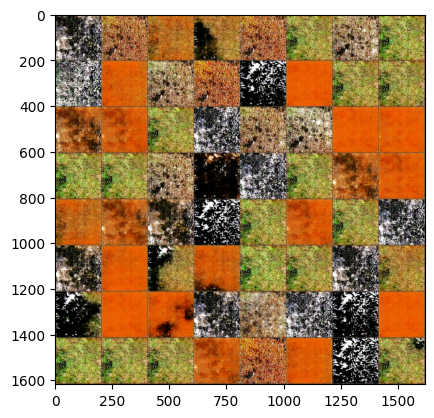

In [ ]:
# training loop for old DCGAN model of KTH-TIPS RGB
criterion = nn.BCELoss()

D = Discriminator(img_channels=3).to(device)
G = Generator(z_dim=z_dim, img_channels=3).to(device)


def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            nn.init.constant_(m.bias, 0)


G.apply(weights_init)
D.apply(weights_init)

optimizerD = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.999))  # D slower
optimizerG = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))

start_epoch = 40
best_fid = float("inf")

if os.path.exists("savedModels/DCGAN_KPT_TIPS_RGB/flipping/checkpoint[21-40].pth"):
    print("Loading checkpoint...")
    checkpoint = torch.load(
        "savedModels/DCGAN_KPT_TIPS_RGB/flipping/checkpoint[21-40].pth",
        map_location=device,
    )
    D.load_state_dict(checkpoint["discriminator_state_dict"])
    G.load_state_dict(checkpoint["generator_state_dict"])
    optimizerD.load_state_dict(checkpoint["optimizerD_state_dict"])
    optimizerG.load_state_dict(checkpoint["optimizerG_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    best_fid = checkpoint.get("fid", float("inf"))

end_epoch = start_epoch + 100

# Logging
losses_G, losses_D, scores_real, scores_fake = [], [], [], []
collect_x_gen = []
fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

fig = plt.figure()
plt.ion()

# FID setup
fid = FrechetInceptionDistance(feature=2048).to(device)

for epoch in range(start_epoch, end_epoch):
    for i, (x_real, _) in enumerate(dataloader, 0):
        x_real = x_real.to(device)
        batch_size = x_real.size(0)

        # Labels with smoothing + occasional noisy flips
        lab_real = torch.ones(batch_size, 1, device=device) * 0.9
        lab_fake = torch.zeros(batch_size, 1, device=device)
        if torch.rand(1).item() < 0.05:  # 5% chance to flip
            lab_real, lab_fake = lab_fake, lab_real

        # -------------------------
        # STEP 1: Train Discriminator
        # -------------------------
        optimizerD.zero_grad()

        # Real
        D_x = D(x_real)
        lossD_real = criterion(D_x, lab_real)

        # Fake
        z = torch.randn(batch_size, z_dim, 1, 1, device=device)
        x_gen = G(z).detach()
        D_G_z_fake = D(x_gen)
        lossD_fake = criterion(D_G_z_fake, lab_fake)

        # Total D loss
        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        # -------------------------
        # STEP 2: Train Generator (multiple steps)
        # -------------------------
        for _ in range(2):  # train G twice per D step
            optimizerG.zero_grad()
            z = torch.randn(batch_size, z_dim, 1, 1, device=device)
            x_gen = G(z)
            D_G_z = D(x_gen)
            lossG = criterion(D_G_z, lab_real)  # G wants D to output "real"
            lossG.backward()
            optimizerG.step()

        # -------------------------
        # Logging
        # -------------------------
        losses_G.append(lossG.item())
        losses_D.append(lossD.item())
        scores_real.append(D_x.mean().item())
        scores_fake.append(D_G_z.mean().item())

        if i % 100 == 0:
            x_gen = G(fixed_noise)
            show_imgs(x_gen, newFig=False)
            fig.canvas.draw()
            print(
                f"Epoch [{epoch}/{end_epoch}] Step [{i}/{len(dataloader)}] "
                f"D(x)={D_x.mean().item():.4f} D(G(z))={D_G_z.mean().item():.4f} "
                f"Loss_D={lossD.item():.4f} Loss_G={lossG.item():.4f}"
            )

    # End of epoch snapshot
    with torch.no_grad():
        x_gen = G(fixed_noise)
        collect_x_gen.append(x_gen.detach().clone())

    # -------------------------
    # FID Evaluation every 5 epochs
    # -------------------------
    if (epoch + 1) % 5 == 0:
        fid.reset()

        # Real images
        for real_batch, _ in dataloader:
            real_batch_uint8 = preprocess_for_fid(real_batch.to(device))
            fid.update(real_batch_uint8, real=True)

        # Fake images
        with torch.no_grad():
            for _ in range(len(dataloader)):
                noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
                fake_images = G(noise)
                fake_images_uint8 = preprocess_for_fid(fake_images)
                fid.update(fake_images_uint8, real=False)

        fid_score = fid.compute().item()
        print(f"FID score at epoch {epoch+1}: {fid_score:.4f}")

        # Save best model
        if fid_score < best_fid:
            best_fid = fid_score
            torch.save(
                {
                    "epoch": epoch,
                    "generator_state_dict": G.state_dict(),
                    "discriminator_state_dict": D.state_dict(),
                    "optimizerG_state_dict": optimizerG.state_dict(),
                    "optimizerD_state_dict": optimizerD.state_dict(),
                    "fid": best_fid,
                },
                "savedModels/DCGAN_KPT_TIPS_RGB/best_checkpoint.pth",
            )
            print(f"✅ New best FID {best_fid:.4f}, checkpoint saved!")

        # Save latest checkpoint always
        torch.save(
            {
                "epoch": epoch,
                "generator_state_dict": G.state_dict(),
                "discriminator_state_dict": D.state_dict(),
                "optimizerG_state_dict": optimizerG.state_dict(),
                "optimizerD_state_dict": optimizerD.state_dict(),
                "fid": fid_score,
            },
            "savedModels/DCGAN_KPT_TIPS_RGB/latest_checkpoint.pth",
        )

In [8]:
# training loop for enhanced DCGAN model of KTH-TIPS RGB
z_dim = 100

G = Generator(z_dim=z_dim, img_channels=3).to(device)
D = Discriminator(img_channels=3).to(device)


def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            nn.init.constant_(m.bias, 0)


G.apply(weights_init)
D.apply(weights_init)

optimizerD = torch.optim.Adam(D.parameters(), lr=4e-4, betas=(0.0, 0.99))
optimizerG = torch.optim.Adam(G.parameters(), lr=1e-4, betas=(0.0, 0.99))

start_epoch = 0
best_fid = float("inf")
losses_G, losses_D = [], []

# load checkpoint if exists
if os.path.exists("savedModels/DCGAN_KPT_TIPS_RGB/latest_checkpoint_v2.pth"):
    print("Loading checkpoint...")
    checkpoint = torch.load(
        "savedModels/DCGAN_KPT_TIPS_RGB/latest_checkpoint_v2.pth", map_location=device
    )
    D.load_state_dict(checkpoint["discriminator_state_dict"])
    G.load_state_dict(checkpoint["generator_state_dict"])
    optimizerD.load_state_dict(checkpoint["optimizerD_state_dict"])
    optimizerG.load_state_dict(checkpoint["optimizerG_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    best_fid = checkpoint.get("fid", float("inf"))
    losses_G = checkpoint.get("losses_G", [])
    losses_D = checkpoint.get("losses_D", [])
    print(f"Resuming from epoch {start_epoch} with best FID {best_fid:.4f}")

epochs = start_epoch + 80
fixed_noise = torch.randn(64, z_dim, device=device)
fid = FrechetInceptionDistance(feature=2048).to(device)


for epoch in range(start_epoch, epochs):
    D.train()
    G.train()
    epoch_loss_G, epoch_loss_D = 0, 0

    for i, (x_real, _) in enumerate(tqdm(dataloader)):
        x_real = x_real.to(device)
        b_size = x_real.size(0)

        # --- Train D ---
        z = torch.randn(b_size, z_dim, device=device)
        x_fake = G(z).detach()
        D_real = D(x_real)
        D_fake = D(x_fake)

        lossD = torch.mean(F.relu(1.0 - D_real)) + torch.mean(F.relu(1.0 + D_fake))
        optimizerD.zero_grad()
        lossD.backward()
        optimizerD.step()

        # --- Train G ---
        z = torch.randn(b_size, z_dim, device=device)
        x_fake = G(z)
        D_fake = D(x_fake)
        lossG = -torch.mean(D_fake)

        optimizerG.zero_grad()
        lossG.backward()
        optimizerG.step()

        epoch_loss_G += lossG.item()
        epoch_loss_D += lossD.item()

    # Average losses per epoch
    losses_G.append(epoch_loss_G / len(dataloader))
    losses_D.append(epoch_loss_D / len(dataloader))

    print(
        f"Epoch [{epoch+1}/{epochs}] | Loss_D: {losses_D[-1]:.4f} | Loss_G: {losses_G[-1]:.4f}"
    )

    # --- FID evaluation every 5 epochs ---
    if (epoch + 1) % 5 == 0:
        fid.reset()
        with torch.no_grad():
            for real_batch, _ in dataloader:
                real_uint8 = preprocess_for_fid(real_batch.to(device))
                fid.update(real_uint8, real=True)

            for _ in range(len(dataloader)):
                noise = torch.randn(b_size, z_dim, device=device)
                fake_images = G(noise)
                fake_uint8 = preprocess_for_fid(fake_images)
                fid.update(fake_uint8, real=False)

        fid_score = fid.compute().item()
        print(f"FID score at epoch {epoch+1}: {fid_score:.4f}")

        if fid_score < best_fid:
            best_fid = fid_score
            torch.save(
                {
                    "epoch": epoch,
                    "generator_state_dict": G.state_dict(),
                    "discriminator_state_dict": D.state_dict(),
                    "optimizerG_state_dict": optimizerG.state_dict(),
                    "optimizerD_state_dict": optimizerD.state_dict(),
                    "fid": best_fid,
                    "losses_G": losses_G,
                    "losses_D": losses_D,
                },
                "savedModels/DCGAN_KPT_TIPS_RGB/best_checkpoint_v2.pth",
            )
            print(f"✅ New best FID {best_fid:.4f}, checkpoint saved!")

Loading checkpoint...
Resuming from epoch 420 with best FID 206.8255


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [06:36<00:00,  5.28s/it]


Epoch [421/500] | Loss_D: 0.1564 | Loss_G: 2.4439


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [06:09<00:00,  4.93s/it]


Epoch [422/500] | Loss_D: 0.2200 | Loss_G: 2.5726


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:32<00:00,  4.44s/it]


Epoch [423/500] | Loss_D: 0.0749 | Loss_G: 2.3961


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:33<00:00,  4.45s/it]


Epoch [424/500] | Loss_D: 0.1654 | Loss_G: 2.4679


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:36<00:00,  4.49s/it]


Epoch [425/500] | Loss_D: 0.1357 | Loss_G: 2.4281
FID score at epoch 425: 239.9213


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:28<00:00,  4.38s/it]


Epoch [426/500] | Loss_D: 0.2198 | Loss_G: 2.3890


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:36<00:00,  4.48s/it]


Epoch [427/500] | Loss_D: 0.1661 | Loss_G: 2.2838


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:32<00:00,  4.44s/it]


Epoch [428/500] | Loss_D: 0.2157 | Loss_G: 2.3173


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:33<00:00,  4.45s/it]


Epoch [429/500] | Loss_D: 0.1514 | Loss_G: 2.3711


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:34<00:00,  4.46s/it]


Epoch [430/500] | Loss_D: 0.1417 | Loss_G: 2.2800
FID score at epoch 430: 228.9534


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:33<00:00,  4.45s/it]


Epoch [431/500] | Loss_D: 0.1656 | Loss_G: 2.4631


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:38<00:00,  4.52s/it]


Epoch [432/500] | Loss_D: 0.1473 | Loss_G: 2.4256


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:42<00:00,  4.57s/it]


Epoch [433/500] | Loss_D: 0.1554 | Loss_G: 2.4365


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:39<00:00,  4.53s/it]


Epoch [434/500] | Loss_D: 0.1478 | Loss_G: 2.4639


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:39<00:00,  4.52s/it]


Epoch [435/500] | Loss_D: 0.1793 | Loss_G: 2.4200
FID score at epoch 435: 241.2508


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:35<00:00,  4.48s/it]


Epoch [436/500] | Loss_D: 0.2098 | Loss_G: 2.5457


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:33<00:00,  4.44s/it]


Epoch [437/500] | Loss_D: 0.1524 | Loss_G: 2.3914


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:35<00:00,  4.48s/it]


Epoch [438/500] | Loss_D: 0.1147 | Loss_G: 2.3073


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:31<00:00,  4.42s/it]


Epoch [439/500] | Loss_D: 0.1908 | Loss_G: 2.4282


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:33<00:00,  4.44s/it]


Epoch [440/500] | Loss_D: 0.1191 | Loss_G: 2.3138
FID score at epoch 440: 228.8298


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:34<00:00,  4.46s/it]


Epoch [441/500] | Loss_D: 0.1452 | Loss_G: 2.5248


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:34<00:00,  4.46s/it]


Epoch [442/500] | Loss_D: 0.2057 | Loss_G: 2.4213


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:32<00:00,  4.43s/it]


Epoch [443/500] | Loss_D: 0.1292 | Loss_G: 2.4600


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:37<00:00,  4.50s/it]


Epoch [444/500] | Loss_D: 0.1322 | Loss_G: 2.2239


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:33<00:00,  4.45s/it]


Epoch [445/500] | Loss_D: 0.1772 | Loss_G: 2.3122
FID score at epoch 445: 238.4053


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:38<00:00,  4.51s/it]


Epoch [446/500] | Loss_D: 0.1421 | Loss_G: 2.3290


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:38<00:00,  4.51s/it]


Epoch [447/500] | Loss_D: 0.1601 | Loss_G: 2.4504


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:37<00:00,  4.50s/it]


Epoch [448/500] | Loss_D: 0.1001 | Loss_G: 2.3406


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:38<00:00,  4.51s/it]


Epoch [449/500] | Loss_D: 0.2842 | Loss_G: 2.3490


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:40<00:00,  4.54s/it]


Epoch [450/500] | Loss_D: 0.1430 | Loss_G: 2.4203
FID score at epoch 450: 222.4429


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:37<00:00,  4.50s/it]


Epoch [451/500] | Loss_D: 0.1205 | Loss_G: 2.4035


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:37<00:00,  4.50s/it]


Epoch [452/500] | Loss_D: 0.2272 | Loss_G: 2.2517


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:34<00:00,  4.46s/it]


Epoch [453/500] | Loss_D: 0.1262 | Loss_G: 2.3171


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:32<00:00,  4.43s/it]


Epoch [454/500] | Loss_D: 0.1515 | Loss_G: 2.3432


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:31<00:00,  4.42s/it]


Epoch [455/500] | Loss_D: 0.1878 | Loss_G: 2.2889
FID score at epoch 455: 221.4368


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:33<00:00,  4.45s/it]


Epoch [456/500] | Loss_D: 0.1731 | Loss_G: 2.3926


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:31<00:00,  4.42s/it]


Epoch [457/500] | Loss_D: 0.1722 | Loss_G: 2.4137


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:32<00:00,  4.43s/it]


Epoch [458/500] | Loss_D: 0.1202 | Loss_G: 2.4379


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:30<00:00,  4.41s/it]


Epoch [459/500] | Loss_D: 0.1353 | Loss_G: 2.4961


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:32<00:00,  4.43s/it]


Epoch [460/500] | Loss_D: 0.1354 | Loss_G: 2.5504
FID score at epoch 460: 235.0224


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:35<00:00,  4.48s/it]


Epoch [461/500] | Loss_D: 0.1920 | Loss_G: 2.4742


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:33<00:00,  4.44s/it]


Epoch [462/500] | Loss_D: 0.1616 | Loss_G: 2.3028


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:34<00:00,  4.47s/it]


Epoch [463/500] | Loss_D: 0.1280 | Loss_G: 2.4003


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:35<00:00,  4.48s/it]


Epoch [464/500] | Loss_D: 0.1110 | Loss_G: 2.4190


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:36<00:00,  4.49s/it]


Epoch [465/500] | Loss_D: 0.1472 | Loss_G: 2.4808
FID score at epoch 465: 192.8110
✅ New best FID 192.8110, checkpoint saved!


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:37<00:00,  4.50s/it]


Epoch [466/500] | Loss_D: 0.1356 | Loss_G: 2.5624


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:34<00:00,  4.47s/it]


Epoch [467/500] | Loss_D: 0.1229 | Loss_G: 2.5810


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:37<00:00,  4.50s/it]


Epoch [468/500] | Loss_D: 0.1156 | Loss_G: 2.4914


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:37<00:00,  4.50s/it]


Epoch [469/500] | Loss_D: 0.1022 | Loss_G: 2.3482


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:35<00:00,  4.48s/it]


Epoch [470/500] | Loss_D: 0.1758 | Loss_G: 2.2698
FID score at epoch 470: 225.2204


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:38<00:00,  4.51s/it]


Epoch [471/500] | Loss_D: 0.0745 | Loss_G: 2.5409


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:34<00:00,  4.46s/it]


Epoch [472/500] | Loss_D: 0.1704 | Loss_G: 2.4478


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:33<00:00,  4.44s/it]


Epoch [473/500] | Loss_D: 0.1734 | Loss_G: 2.3479


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:34<00:00,  4.46s/it]


Epoch [474/500] | Loss_D: 0.1217 | Loss_G: 2.3744


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:35<00:00,  4.47s/it]


Epoch [475/500] | Loss_D: 0.1488 | Loss_G: 2.3850
FID score at epoch 475: 243.3164


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:33<00:00,  4.45s/it]


Epoch [476/500] | Loss_D: 0.1108 | Loss_G: 2.2771


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:35<00:00,  4.48s/it]


Epoch [477/500] | Loss_D: 0.1888 | Loss_G: 2.3810


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:36<00:00,  4.49s/it]


Epoch [478/500] | Loss_D: 0.1850 | Loss_G: 2.3276


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:35<00:00,  4.48s/it]


Epoch [479/500] | Loss_D: 0.1153 | Loss_G: 2.3769


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:38<00:00,  4.52s/it]


Epoch [480/500] | Loss_D: 0.1625 | Loss_G: 2.4850
FID score at epoch 480: 239.2727


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:38<00:00,  4.51s/it]


Epoch [481/500] | Loss_D: 0.1139 | Loss_G: 2.4513


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:41<00:00,  4.55s/it]


Epoch [482/500] | Loss_D: 0.1516 | Loss_G: 2.5746


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:38<00:00,  4.51s/it]


Epoch [483/500] | Loss_D: 0.1188 | Loss_G: 2.3592


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:36<00:00,  4.49s/it]


Epoch [484/500] | Loss_D: 0.1608 | Loss_G: 2.4535


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:36<00:00,  4.49s/it]


Epoch [485/500] | Loss_D: 0.1511 | Loss_G: 2.5068
FID score at epoch 485: 207.4043


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:37<00:00,  4.50s/it]


Epoch [486/500] | Loss_D: 0.1145 | Loss_G: 2.2500


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:35<00:00,  4.47s/it]


Epoch [487/500] | Loss_D: 0.1271 | Loss_G: 2.5363


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:39<00:00,  4.53s/it]


Epoch [488/500] | Loss_D: 0.0933 | Loss_G: 2.5222


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:35<00:00,  4.48s/it]


Epoch [489/500] | Loss_D: 0.1615 | Loss_G: 2.7320


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:35<00:00,  4.47s/it]


Epoch [490/500] | Loss_D: 0.1326 | Loss_G: 2.3996
FID score at epoch 490: 233.9965


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:43<00:00,  4.58s/it]


Epoch [491/500] | Loss_D: 0.2227 | Loss_G: 2.5936


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:34<00:00,  4.46s/it]


Epoch [492/500] | Loss_D: 0.0899 | Loss_G: 2.4376


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:33<00:00,  4.45s/it]


Epoch [493/500] | Loss_D: 0.1822 | Loss_G: 2.6173


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:34<00:00,  4.45s/it]


Epoch [494/500] | Loss_D: 0.1794 | Loss_G: 2.4088


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:37<00:00,  4.50s/it]


Epoch [495/500] | Loss_D: 0.1041 | Loss_G: 2.3041
FID score at epoch 495: 210.6954


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:38<00:00,  4.52s/it]


Epoch [496/500] | Loss_D: 0.1643 | Loss_G: 2.4134


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:40<00:00,  4.55s/it]


Epoch [497/500] | Loss_D: 0.1364 | Loss_G: 2.5176


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:38<00:00,  4.52s/it]


Epoch [498/500] | Loss_D: 0.1062 | Loss_G: 2.5202


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:37<00:00,  4.49s/it]


Epoch [499/500] | Loss_D: 0.2081 | Loss_G: 2.3665


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [05:37<00:00,  4.50s/it]


Epoch [500/500] | Loss_D: 0.0789 | Loss_G: 2.2635
FID score at epoch 500: 247.3658


In [29]:
# ===================== TRAINING LOOP (Hinge + SpecNorm + Label Smoothing + Noise) =====================
D = Discriminator(img_channels=3, feature_d=64).to(device)
G = Generator(z_dim=z_dim, img_channels=3, feature_g=96).to(device)


# Optional: weight initialization
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            nn.init.constant_(m.bias, 0)


G.apply(weights_init)
D.apply(weights_init)

optimizerD = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))

# Training setup
epochs = 30
fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

# Logging containers
losses_G, losses_D, scores_real, scores_fake = [], [], [], []

fid = FrechetInceptionDistance(feature=2048).to(device)

for epoch in range(epochs):
    G.train()
    D.train()

    for i, (x_real, _) in enumerate(tqdm(dataloader)):
        x_real = x_real.to(device)
        batch_size = x_real.size(0)

        # -----------------------------
        # STEP 1: Train Discriminator
        # -----------------------------
        optimizerD.zero_grad()

        # Add instance noise (regularization trick)
        noise_std = 0.1 * max(0, 1 - epoch / epochs)  # gradually reduce over epochs
        x_real_noisy = x_real + noise_std * torch.randn_like(x_real)

        # Generate fake images
        z = torch.randn(batch_size, z_dim, device=device)
        x_fake = G(z).detach()
        x_fake_noisy = x_fake + noise_std * torch.randn_like(x_fake)

        # Raw discriminator outputs (no sigmoid in hinge)
        D_real = D(x_real_noisy)
        D_fake = D(x_fake_noisy)

        # Hinge loss for discriminator
        lossD_real = torch.mean(F.relu(1.0 - D_real))
        lossD_fake = torch.mean(F.relu(1.0 + D_fake))
        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        # -----------------------------
        # STEP 2: Train Generator
        # -----------------------------
        optimizerG.zero_grad()

        z = torch.randn(batch_size, z_dim, device=device)
        x_gen = G(z)
        D_G_z = D(x_gen)

        # Hinge loss for generator (maximize D(G(z)))
        lossG = -torch.mean(D_G_z)
        lossG.backward()
        optimizerG.step()

        # -----------------------------
        # Logging
        # -----------------------------
        losses_D.append(lossD.item())
        losses_G.append(lossG.item())
        scores_real.append(D_real.mean().item())
        scores_fake.append(D_fake.mean().item())

    print(
        f"Epoch [{epoch+1}/{epochs}] | LossD={lossD.item():.4f} | LossG={lossG.item():.4f} "
        f"| D(x)={D_real.mean().item():.4f} | D(G(z))={D_fake.mean().item():.4f}"
    )

# ===================== END TRAINING LOOP =====================

100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [43:57<00:00, 35.16s/it]


Epoch [1/30] | LossD=0.0086 | LossG=-1.3016 | D(x)=1.0868 | D(G(z))=-1.1005


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [40:25<00:00, 32.34s/it]


Epoch [2/30] | LossD=0.0001 | LossG=-1.4515 | D(x)=1.1404 | D(G(z))=-1.1344


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [40:17<00:00, 32.23s/it]


Epoch [3/30] | LossD=0.0004 | LossG=-1.4653 | D(x)=1.0914 | D(G(z))=-1.1693


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [40:26<00:00, 32.36s/it]


Epoch [4/30] | LossD=0.0007 | LossG=-1.5370 | D(x)=1.0989 | D(G(z))=-1.1857


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [40:44<00:00, 32.59s/it]


Epoch [5/30] | LossD=0.0000 | LossG=-1.5349 | D(x)=1.1762 | D(G(z))=-1.1760


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [46:20<00:00, 37.08s/it]


Epoch [6/30] | LossD=0.0000 | LossG=-1.5420 | D(x)=1.1981 | D(G(z))=-1.2054


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [46:44<00:00, 37.39s/it]


Epoch [7/30] | LossD=0.0008 | LossG=-1.4026 | D(x)=1.1356 | D(G(z))=-1.2239


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [43:07<00:00, 34.49s/it]


Epoch [8/30] | LossD=0.0003 | LossG=-1.6452 | D(x)=1.1706 | D(G(z))=-1.1693


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [43:27<00:00, 34.77s/it]


Epoch [9/30] | LossD=0.0018 | LossG=-1.7126 | D(x)=1.0874 | D(G(z))=-1.2122


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [46:20<00:00, 37.07s/it]


Epoch [10/30] | LossD=0.0001 | LossG=-1.6890 | D(x)=1.1264 | D(G(z))=-1.2688


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [43:30<00:00, 34.81s/it]


Epoch [11/30] | LossD=0.0000 | LossG=-1.6764 | D(x)=1.1798 | D(G(z))=-1.2393


100%|█████████████████████████████████████████████████████████████████████████████████| 75/75 [1:13:46<00:00, 59.02s/it]


Epoch [12/30] | LossD=0.0001 | LossG=-1.7288 | D(x)=1.2706 | D(G(z))=-1.2658


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [49:38<00:00, 39.71s/it]


Epoch [13/30] | LossD=0.0793 | LossG=-1.8902 | D(x)=0.9275 | D(G(z))=-1.2755


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [44:32<00:00, 35.63s/it]


Epoch [14/30] | LossD=0.5111 | LossG=-2.0805 | D(x)=0.4890 | D(G(z))=-1.2813


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [44:05<00:00, 35.28s/it]


Epoch [15/30] | LossD=0.1186 | LossG=-1.3878 | D(x)=0.9477 | D(G(z))=-1.1924


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [44:00<00:00, 35.21s/it]


Epoch [16/30] | LossD=0.4921 | LossG=-0.3025 | D(x)=0.8000 | D(G(z))=-0.7567


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [44:03<00:00, 35.25s/it]


Epoch [17/30] | LossD=0.4047 | LossG=0.5124 | D(x)=1.0479 | D(G(z))=-0.6325


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [44:07<00:00, 35.31s/it]


Epoch [18/30] | LossD=1.2537 | LossG=-1.7356 | D(x)=-0.2537 | D(G(z))=-2.0253


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [44:05<00:00, 35.28s/it]


Epoch [19/30] | LossD=0.9191 | LossG=-0.6208 | D(x)=0.0817 | D(G(z))=-1.5660


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [44:06<00:00, 35.29s/it]


Epoch [20/30] | LossD=1.2072 | LossG=0.0572 | D(x)=0.5677 | D(G(z))=-0.2355


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [44:03<00:00, 35.25s/it]


Epoch [21/30] | LossD=1.0044 | LossG=0.5302 | D(x)=0.8159 | D(G(z))=-0.2205


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [44:33<00:00, 35.65s/it]


Epoch [22/30] | LossD=1.0433 | LossG=0.6949 | D(x)=0.1090 | D(G(z))=-0.9892


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [44:05<00:00, 35.27s/it]


Epoch [23/30] | LossD=1.4050 | LossG=0.0684 | D(x)=-0.1351 | D(G(z))=-0.7849


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [44:41<00:00, 35.76s/it]


Epoch [24/30] | LossD=1.7871 | LossG=-0.0893 | D(x)=0.3387 | D(G(z))=0.1189


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [45:08<00:00, 36.12s/it]


Epoch [25/30] | LossD=1.3644 | LossG=1.2084 | D(x)=0.0133 | D(G(z))=-0.6884


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [44:34<00:00, 35.66s/it]


Epoch [26/30] | LossD=1.2241 | LossG=0.2490 | D(x)=0.6768 | D(G(z))=-0.2119


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [51:40<00:00, 41.34s/it]


Epoch [27/30] | LossD=1.9023 | LossG=0.3038 | D(x)=-0.5497 | D(G(z))=-0.7292


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [53:55<00:00, 43.15s/it]


Epoch [28/30] | LossD=1.7071 | LossG=0.3937 | D(x)=-0.1739 | D(G(z))=-0.4780


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [48:14<00:00, 38.60s/it]


Epoch [29/30] | LossD=1.8428 | LossG=0.3717 | D(x)=0.0021 | D(G(z))=-0.1551


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [49:28<00:00, 39.58s/it]


Epoch [30/30] | LossD=2.5299 | LossG=0.4477 | D(x)=-0.8213 | D(G(z))=-0.2917


In [9]:
torch.save(
    {
        "epoch": epoch,
        "generator_state_dict": G.state_dict(),
        "discriminator_state_dict": D.state_dict(),
        "optimizerG_state_dict": optimizerG.state_dict(),
        "optimizerD_state_dict": optimizerD.state_dict(),
        "fid": fid_score,
    },
    "savedModels/DCGAN_KPT_TIPS_RGB/latest_checkpoint_v2.pth",
)

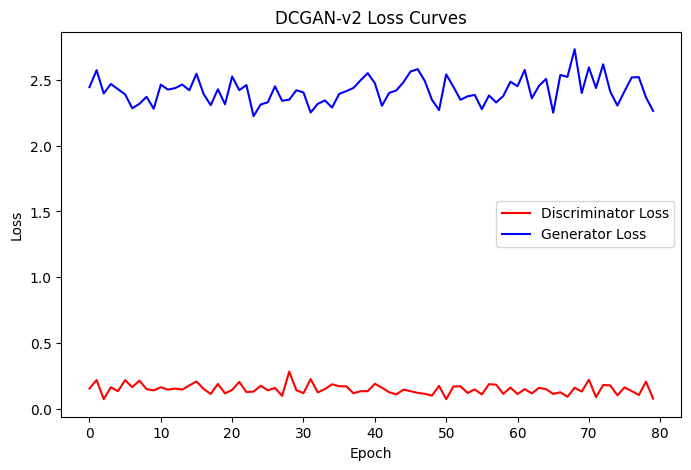

In [10]:
# loss plots for enhanced DCGAN model
plt.figure(figsize=(8, 5))
plt.plot(losses_D, label="Discriminator Loss", color="red")
plt.plot(losses_G, label="Generator Loss", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("DCGAN-v2 Loss Curves")
plt.legend()
plt.show()

In [10]:
best_fid

12.880247116088867

In [11]:
index = 0
for images in collect_x_gen:
    show_imgs(images)
    plt.title("epoch {}".format(start_epoch + index))
    index += 1

NameError: name 'collect_x_gen' is not defined

In [ ]:
# for grayscale KTH-TIPS images
def preprocess_for_fid(imgs: torch.Tensor) -> torch.Tensor:
    """
    Convert KTH-TIPS GAN images from [-1,1], shape (N,1,200,200)
    → uint8 [0,255], shape (N,3,299,299) for FID.
    """
    # [-1,1] → [0,1]
    imgs = (imgs + 1) / 2.0

    # Resize to (299,299) before uint8 conversion
    imgs = F.interpolate(imgs, size=(299, 299), mode="bilinear", align_corners=False)

    # Scale to [0,255]
    imgs = (imgs * 255).clamp(0, 255).to(torch.uint8)

    # Repeat grayscale channel to RGB
    imgs = imgs.repeat(1, 3, 1, 1)

    return imgs

In [6]:
# for RGB KTH-TIPS images
def preprocess_for_fid(imgs: torch.Tensor) -> torch.Tensor:
    """
    Inputs:  GAN outputs or real batches in [-1,1], shape (N,3,200,200)
    Return:  uint8 [0,255], shape (N,3,299,299) for FID (Inception-v3)
    """
    imgs = (imgs + 1) / 2.0  # [-1,1] -> [0,1]
    imgs = F.interpolate(imgs, size=(299, 299), mode="bilinear", align_corners=False)
    imgs = (imgs * 255).clamp(0, 255).to(torch.uint8)
    return imgs

In [37]:
fid = FrechetInceptionDistance(feature=2048).to(device)
D = Discriminator(img_channels=3).to(device)
G = Generator(z_dim=z_dim, img_channels=3, feature_g=96).to(device)
optimizerD = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))

checkpoint = torch.load(
    # "savedModels/DCGAN_KPT_TIPS_RGB/flipping/checkpoint[21-40].pth", map_location=device
    "savedModels/DCGAN_KPT_TIPS_RGB/latest_checkpoint_v3.pth",
    map_location=device,
)

D.load_state_dict(checkpoint["discriminator_state_dict"])
G.load_state_dict(checkpoint["generator_state_dict"])
optimizerD.load_state_dict(checkpoint["optimizerD_state_dict"])
optimizerG.load_state_dict(checkpoint["optimizerG_state_dict"])

for real_imgs, _ in dataloader:
    real_imgs = real_imgs.to(device)
    real_uint8 = preprocess_for_fid(real_imgs)
    fid.update(real_uint8, real=True)

for _ in range(len(dataloader)):
    z = torch.randn(64, z_dim, device=device)
    fake_imgs = G(z)
    fake_uint8 = preprocess_for_fid(fake_imgs)
    fid.update(fake_uint8, real=False)
print("FID score:", fid.compute().item())

FID score: 367.2369689941406


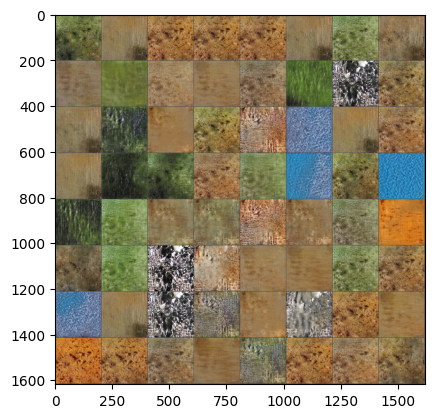

In [15]:
# get generated samples
D = Discriminator(img_channels=3).to(device)
G = Generator(z_dim=z_dim, img_channels=3).to(device)

# for enhanced DCGAN model_v3
# optimizerD = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.999))
# optimizerG = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))

# for enhanced DCGAN model_v2
optimizerD = torch.optim.Adam(D.parameters(), lr=4e-4, betas=(0.0, 0.99))
optimizerG = torch.optim.Adam(G.parameters(), lr=1e-4, betas=(0.0, 0.99))

checkpoint = torch.load(
    # "savedModels/DCGAN_KPT_TIPS_RGB/noFlipping/checkpoint[21-40].pth",
    "savedModels/DCGAN_KPT_TIPS_RGB/best_checkpoint_v2.pth",
    map_location=device,
)
D.load_state_dict(checkpoint["discriminator_state_dict"])
G.load_state_dict(checkpoint["generator_state_dict"])
optimizerD.load_state_dict(checkpoint["optimizerD_state_dict"])
optimizerG.load_state_dict(checkpoint["optimizerG_state_dict"])

z = torch.randn(64, z_dim, device=device)
x_gen = G(z)
show_imgs(x_gen)

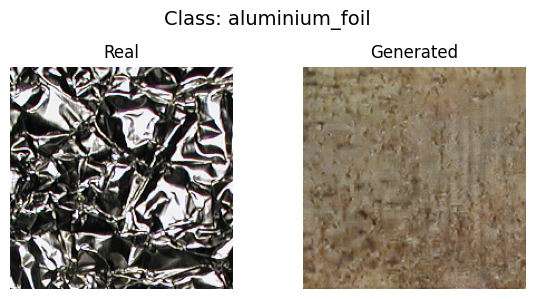

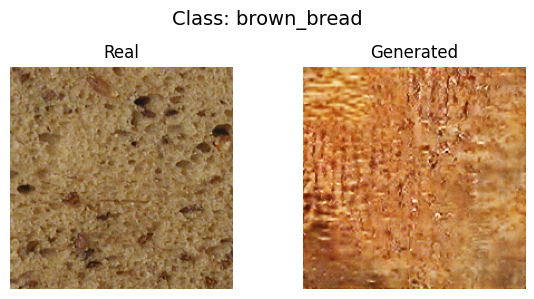

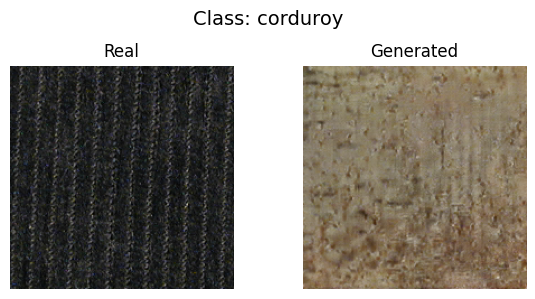

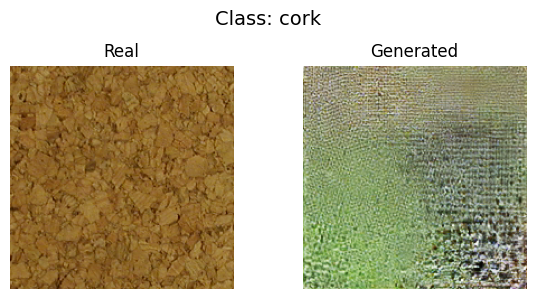

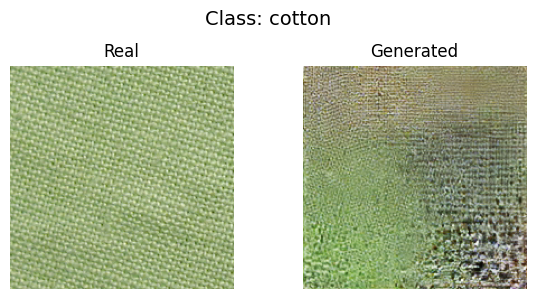

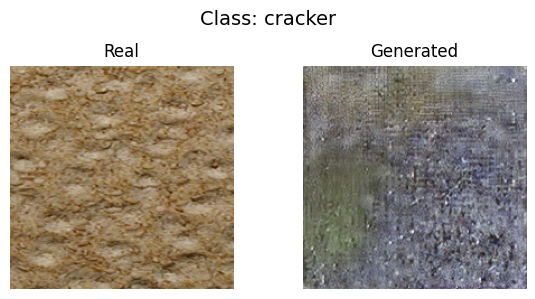

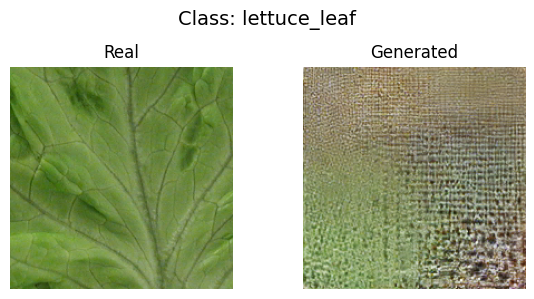

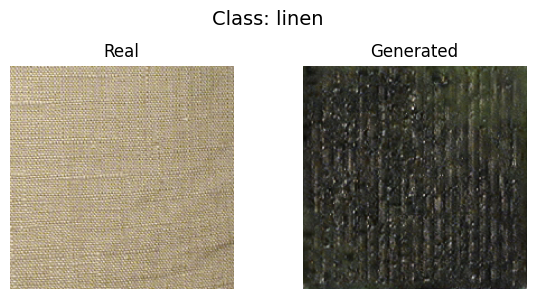

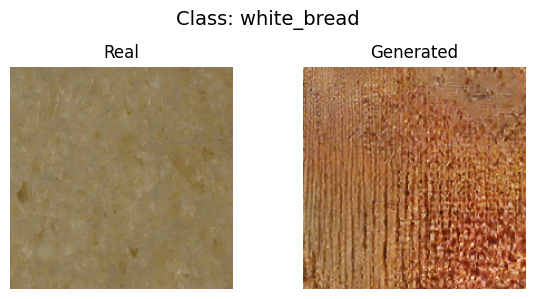

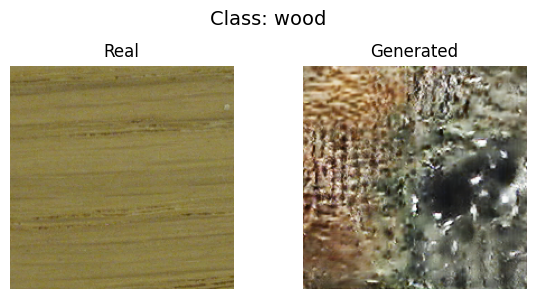

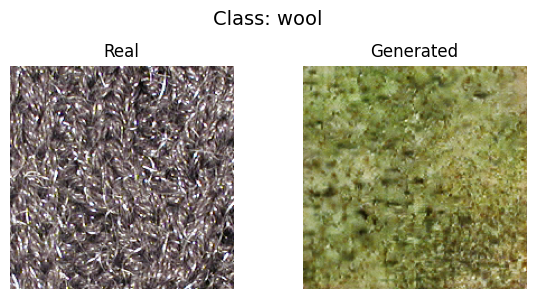

In [36]:
# per-class generated image comparison

G = Generator(z_dim=z_dim, img_channels=3).to(device)
checkpoint = torch.load(
    "savedModels/DCGAN_KPT_TIPS_RGB/latest_checkpoint_v2.pth", map_location=device
)
G.load_state_dict(checkpoint["generator_state_dict"])
# Put model in eval mode
G.eval()

# Access dataset (assuming it's ImageFolder)
dataset = dataloader.dataset
classes = dataset.classes
num_classes = len(classes)

# Generate random latent vectors for each class
z = torch.randn(num_classes, z_dim, device=device)
with torch.no_grad():
    fake_imgs = G(z).cpu()

# Loop through classes, one figure per class
for i, cls in enumerate(classes):
    # Find all samples for this class
    cls_indices = [
        idx
        for idx, (path, label) in enumerate(dataset.samples)
        if dataset.classes[label] == cls
    ]
    if len(cls_indices) == 0:
        continue

    # Pick a random real sample from that class
    real_idx = random.choice(cls_indices)
    real_path, _ = dataset.samples[real_idx]
    real_img = Image.open(real_path).convert("RGB").resize((200, 200))

    # Get generated image
    fake_img = fake_imgs[i]
    fake_img = (fake_img + 1) / 2.0  # normalize from [-1,1] to [0,1]
    fake_img = vutils.make_grid(fake_img, normalize=False).permute(1, 2, 0).numpy()

    # Plot for this class
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    fig.suptitle(f"Class: {cls}", fontsize=14)

    axes[0].imshow(real_img)
    axes[0].set_title("Real")
    axes[0].axis("off")

    axes[1].imshow(fake_img)
    axes[1].set_title("Generated")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

## Using Diffusion Models
- They add noise to real image until the image is turned into pure noise and then learn how to generate the real image from that pure noise.
- Training goes something like:
    image + noise --> predict noise --> subtract --> clean image
- They are different from DCGAN because of:
    - Stability (no adversarial loss)
    - provides photorealism is trained for SOTA.

Dataset: FFHQ-256

Model: DDPM (Denoising Diffusion Probabilistic Model)

In [3]:
# U-Net
class ResidualBlock(nn.Module):
    def __init__(
        self, in_channels, out_channels, time_emb_dim, dropout=0.1, num_groups=8
    ):
        super().__init__()
        # Adjust num_groups to avoid errors
        groups = num_groups if out_channels % num_groups == 0 else 1

        self.time_mlp = nn.Linear(time_emb_dim, out_channels)

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.GroupNorm(groups, out_channels),
            nn.SiLU(),
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.GroupNorm(groups, out_channels),
            nn.SiLU(),
            nn.Dropout(dropout),
        )

        # for residual connection when in/out channels differ
        self.res_conv = (
            nn.Conv2d(in_channels, out_channels, 1)
            if in_channels != out_channels
            else nn.Identity()
        )

    def forward(self, x, t):
        # project time embedding and add as bias
        t_out = self.time_mlp(t).unsqueeze(-1).unsqueeze(-1)  # (B, C) -> (B,C,1,1)

        h = self.block1(x)
        h = h + t_out
        h = self.block2(h)

        return h + self.res_conv(x)


class UNet(nn.Module):
    def __init__(self, img_channels=3, base_channels=64, time_emb_dim=256):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.Linear(1, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )

        self.enc1 = ResidualBlock(img_channels, base_channels, time_emb_dim)
        self.enc2 = ResidualBlock(base_channels, base_channels * 2, time_emb_dim)
        self.enc3 = ResidualBlock(base_channels * 2, base_channels * 4, time_emb_dim)

        self.middle = ResidualBlock(base_channels * 4, base_channels * 4, time_emb_dim)

        self.dec3 = ResidualBlock(
            base_channels * 4 + base_channels * 4, base_channels * 2, time_emb_dim
        )
        self.dec2 = ResidualBlock(
            base_channels * 2 + base_channels * 2, base_channels, time_emb_dim
        )
        self.dec1 = ResidualBlock(
            base_channels + base_channels, img_channels, time_emb_dim
        )

        self.down = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode="nearest")

    def forward(self, x, t):
        t = self.time_mlp(t)

        # Encoder
        x1 = self.enc1(x, t)  # (B, 64, 256, 256)
        x2 = self.enc2(self.down(x1), t)  # (B, 128, 128, 128)
        x3 = self.enc3(self.down(x2), t)  # (B, 256, 64, 64)

        # Middle
        m = self.middle(self.down(x3), t)  # (B, 256, 32, 32)

        # Decoder
        d3 = self.up(m)  # (B, 256, 64, 64)
        d3 = self.dec3(torch.cat([d3, x3], dim=1), t)  # concat along channels

        d2 = self.up(d3)  # (B, 128?, 128, 128)
        d2 = self.dec2(torch.cat([d2, x2], dim=1), t)

        d1 = self.up(d2)  # (B, 64?, 256, 256)
        out = self.dec1(torch.cat([d1, x1], dim=1), t)

        return out

In [9]:
# beta schedule & forward/reverse diffusion process
def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi / 2) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)


timesteps = 100
betas = cosine_beta_schedule(timesteps).to(device)
alphas = (1.0 - betas).to(device)
alphas_cumprod = torch.cumprod(alphas, dim=0).to(device)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0).to(device)

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod).to(device)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod).to(device)


def forward_diffusion_sample(x_0, t, device="cuda"):
    noise = torch.randn_like(x_0).to(device)

    # ensure buffers are on the same device as t
    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod.to(device)[t].reshape(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod.to(device)[
        t
    ].reshape(-1, 1, 1, 1)

    return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise, noise

In [31]:
dataset_path = "FFHQ-256"  # path where your images are stored

transform = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.5] * 3, [0.5] * 3),  # scale to [-1,1]
    ]
)


class FFHQDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.files = [
            os.path.join(root, f)
            for f in os.listdir(root)
            if f.lower().endswith((".png", ".jpg", ".jpeg"))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img


# Create dataset + dataloader
dataset = FFHQDataset(dataset_path, transform=transform)
dataloader = DataLoader(
    dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True
)

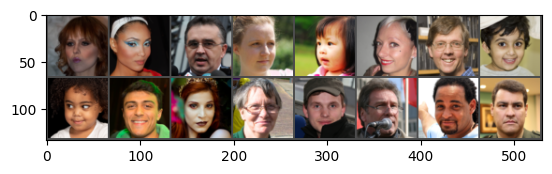

In [16]:
dataiter = iter(dataloader)
images = next(dataiter)
show_imgs(images)

In [ ]:
# training loop
model = UNet(base_channels=32, time_emb_dim=128).to(device)
scaler = torch.cuda.amp.GradScaler()
optimizer = optim.Adam(model.parameters(), lr=2e-4)
epochs_start = 0
# import from checkpoint if exists
if os.path.exists("savedModels/diffusion_unet_ffhq.pth"):
    print("Loading checkpoint...")
    checkpoint = torch.load(
        "savedModels/diffusion_unet_ffhq[6-10].pth", map_location=device
    )
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    scaler.load_state_dict(checkpoint["scaler_state_dict"])
    epoch_start = checkpoint["epochs"] + 1

epochs = 50  # realistically 200+ for FFHQ
end_epoch = epochs_start + epochs

for epoch in range(epochs_start, end_epoch):
    for step, x in enumerate(tqdm(dataloader)):
        x = x.to(device)

        # sample random timesteps
        t = torch.randint(0, timesteps, (x.shape[0],), device=device).long()

        # forward diffusion
        x_noisy, noise = forward_diffusion_sample(x, t, device)
        with torch.cuda.amp.autocast('cuda'):
            noise_pred = model(x_noisy, t.unsqueeze(-1).float())
            loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    print(f"Epoch {epoch+1}/{end_epoch}: Loss={loss.item():.4f}")

100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [11:11<00:00,  6.52it/s]


Epoch 1/50: Loss=0.0487


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [08:51<00:00,  8.24it/s]


Epoch 2/50: Loss=0.0236


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [08:19<00:00,  8.75it/s]


Epoch 3/50: Loss=0.0344


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [08:58<00:00,  8.13it/s]


Epoch 4/50: Loss=0.0786


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [05:58<00:00, 12.21it/s]


Epoch 5/50: Loss=0.0273


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [05:48<00:00, 12.55it/s]


Epoch 6/50: Loss=0.0592


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [05:02<00:00, 14.47it/s]


Epoch 7/50: Loss=0.0490


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [07:23<00:00,  9.86it/s]


Epoch 8/50: Loss=0.0312


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [07:14<00:00, 10.08it/s]


Epoch 9/50: Loss=0.0268


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:49<00:00, 10.67it/s]


Epoch 10/50: Loss=0.0466


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [07:44<00:00,  9.41it/s]


Epoch 11/50: Loss=0.0339


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [14:02<00:00,  5.19it/s]


Epoch 12/50: Loss=0.0251


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:38<00:00, 10.99it/s]


Epoch 13/50: Loss=0.0314


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:41<00:00, 10.90it/s]


Epoch 14/50: Loss=0.0194


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:11<00:00, 11.76it/s]


Epoch 15/50: Loss=0.0401


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:26<00:00, 11.32it/s]


Epoch 16/50: Loss=0.0247


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:20<00:00, 11.48it/s]


Epoch 17/50: Loss=0.0203


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:11<00:00, 11.79it/s]


Epoch 18/50: Loss=0.0456


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:21<00:00, 11.46it/s]


Epoch 19/50: Loss=0.0424


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:08<00:00, 11.88it/s]


Epoch 20/50: Loss=0.0305


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:13<00:00, 11.71it/s]


Epoch 21/50: Loss=0.0267


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:19<00:00, 11.54it/s]


Epoch 22/50: Loss=0.0230


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:16<00:00, 11.61it/s]


Epoch 23/50: Loss=0.0204


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:45<00:00, 10.80it/s]


Epoch 24/50: Loss=0.0278


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:25<00:00, 11.34it/s]


Epoch 25/50: Loss=0.0289


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:43<00:00, 10.83it/s]


Epoch 26/50: Loss=0.0237


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:19<00:00, 11.52it/s]


Epoch 27/50: Loss=0.0314


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:35<00:00, 11.08it/s]


Epoch 28/50: Loss=0.0143


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [07:18<00:00,  9.97it/s]


Epoch 29/50: Loss=0.0454


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [11:33<00:00,  6.31it/s]


Epoch 30/50: Loss=0.0238


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [07:01<00:00, 10.37it/s]


Epoch 31/50: Loss=0.0265


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [07:09<00:00, 10.20it/s]


Epoch 32/50: Loss=0.0317


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [07:00<00:00, 10.39it/s]


Epoch 33/50: Loss=0.0193


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [07:12<00:00, 10.11it/s]


Epoch 34/50: Loss=0.0226


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:46<00:00, 10.77it/s]


Epoch 35/50: Loss=0.0237


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:50<00:00, 10.66it/s]


Epoch 36/50: Loss=0.0293


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:44<00:00, 10.80it/s]


Epoch 37/50: Loss=0.0249


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:51<00:00, 10.64it/s]


Epoch 38/50: Loss=0.0764


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:56<00:00, 10.51it/s]


Epoch 39/50: Loss=0.0389


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:54<00:00, 10.54it/s]


Epoch 40/50: Loss=0.0274


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [07:06<00:00, 10.25it/s]


Epoch 41/50: Loss=0.0284


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [07:34<00:00,  9.63it/s]


Epoch 42/50: Loss=0.0351


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [07:32<00:00,  9.66it/s]


Epoch 43/50: Loss=0.0266


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [07:10<00:00, 10.17it/s]


Epoch 44/50: Loss=0.0270


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [07:24<00:00,  9.84it/s]


Epoch 45/50: Loss=0.0166


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [07:08<00:00, 10.22it/s]


Epoch 46/50: Loss=0.0488


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [07:27<00:00,  9.79it/s]


Epoch 47/50: Loss=0.0248


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [07:16<00:00, 10.01it/s]


Epoch 48/50: Loss=0.0247


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [07:25<00:00,  9.82it/s]


Epoch 49/50: Loss=0.0557


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [07:29<00:00,  9.74it/s]


Epoch 50/50: Loss=0.0436


In [21]:
@torch.no_grad()
def sample_timestep(x, t):
    betas_t = betas[t].to(device)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].to(device)
    sqrt_recip_alphas_t = (1.0 / torch.sqrt(alphas[t])).to(device)

    model_mean = sqrt_recip_alphas_t * (
        x
        - betas_t / sqrt_one_minus_alphas_cumprod_t * model(x, t.unsqueeze(-1).float())
    )

    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x).to(device)
        return model_mean + torch.sqrt(betas[t]) * noise


@torch.no_grad()
def sample_images(model, img_size=64, n=16, timesteps=100):
    model.eval()
    x = torch.randn(n, 3, img_size, img_size, device=device)  # start from noise

    for t in tqdm(reversed(range(timesteps)), desc="Sampling"):
        t_tensor = torch.full((n, 1), t, device=device).float()
        noise_pred = model(x, t_tensor)

        # Ensure tensor indexing
        alpha = alphas_cumprod[t].to(device)
        alpha_prev = (
            alphas_cumprod[t - 1].to(device)
            if t > 0
            else torch.tensor(1.0, device=device)
        )
        beta = 1 - alpha / alpha_prev

        # broadcast scalars correctly
        alpha = alpha.reshape(1, 1, 1, 1)
        alpha_prev = alpha_prev.reshape(1, 1, 1, 1)
        beta = beta.reshape(1, 1, 1, 1)

        x = (x - beta * noise_pred) / torch.sqrt(alpha)
        if t > 0:
            x += torch.sqrt(beta) * torch.randn_like(x)

    x = (x.clamp(-1, 1) + 1) / 2  # back to [0,1]
    return x

In [33]:
# save model checkpoint
checkpoint_path = "savedModels/diffusion_unet_ffhq[50].pth"
checkpoint = {
    "epochs": end_epoch,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "scaler_state_dict": scaler.state_dict(),
}
torch.save(checkpoint, checkpoint_path)

Sampling: 100it [00:00, 112.54it/s]


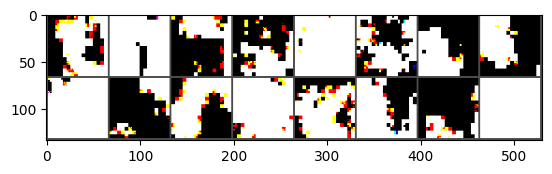

In [34]:
# importing model checkpoint
model = UNet(base_channels=32, time_emb_dim=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-4)
scaler = torch.cuda.amp.GradScaler()

checkpoint = torch.load("savedModels/diffusion_unet_ffhq[50].pth", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
scaler.load_state_dict(checkpoint["scaler_state_dict"])

samples = sample_images(model, img_size=64, n=16, timesteps=100)
show_imgs(samples)

### DCGAN on FFHQ-256

In [1]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size = 200      # Resize input images
batch_size = 12
z_dim = 100
num_epochs_block = 20   # train in blocks of 20 epochs
checkpoint_dir = "savedModels/DCGAN_FFHQ_256/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs("Images/DCGAN_FFHQ_256", exist_ok=True)

In [3]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5 for _ in range(3)], [0.5 for _ in range(3)]) # 3-channel normalize
])

dataset = datasets.ImageFolder(root="ffhq256", transform=transform)

if len(dataset) < 200:
    raise ValueError(f"Dataset too small: {len(dataset)} images found, need at least 200.")

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3, feature_g=64):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, feature_g * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_g * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_g * 8, feature_g * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_g * 4, feature_g * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_g * 2, feature_g, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_g, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

In [5]:
class Discriminator(nn.Module):
    def __init__(self, img_channels=3, feature_d=64):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(img_channels, feature_d, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d, feature_d * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_d * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d * 2, feature_d * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_d * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d * 4, feature_d * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_d * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, x):
        return self.net(x).view(-1)

In [6]:
G = Generator(z_dim=z_dim).to(device)
D = Discriminator().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizerG = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizerD = optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.999))
scaler = torch.cuda.amp.GradScaler()
fixed_noise = torch.randn(16, z_dim, 1, 1, device=device)


C:\Users\Jay\AppData\Local\Temp\ipykernel_17132\139359032.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [7]:
def train_dcgan(start_epoch=0, resume=False):
    if resume and start_epoch > 0:
        # Load from the previous epoch (start_epoch-1)
        g_path = f"{checkpoint_dir}/G_epoch{start_epoch-1}.pth"
        d_path = f"{checkpoint_dir}/D_epoch{start_epoch-1}.pth"
        if os.path.exists(g_path) and os.path.exists(d_path):
            G.load_state_dict(torch.load(g_path, map_location=device))
            D.load_state_dict(torch.load(d_path, map_location=device))
            print(f"✅ Resumed from checkpoints at epoch {start_epoch-1}, continuing from {start_epoch}")
        else:
            print(f"⚠️ No checkpoint found for epoch {start_epoch-1}, training from scratch instead.")

    print(f"\nTraining starts at epoch {start_epoch} for {num_epochs_block} epochs...")
    start_time = time.time()

    for epoch in range(start_epoch, start_epoch + num_epochs_block):
        for i, (real, _) in enumerate(dataloader):
            b_size = real.size(0)
            real = real.to(device, non_blocking=True)
            noise = torch.randn(b_size, z_dim, 1, 1, device=device)

            # ========================
            # Train Discriminator
            # ========================
            with torch.cuda.amp.autocast():
                fake = G(noise)
                label_real = torch.empty_like(D(real)).uniform_(0.9, 1.0)
                label_fake = torch.empty_like(D(fake.detach())).uniform_(0.0, 0.1)
                D_real = D(real)
                D_fake = D(fake.detach())
                lossD = (criterion(D_real, label_real) + criterion(D_fake, label_fake)) / 2

            optimizerD.zero_grad()
            scaler.scale(lossD).backward()
            scaler.step(optimizerD)

            # ========================
            # Train Generator
            # ========================
            with torch.cuda.amp.autocast():
                D_fake_for_G = D(fake)
                lossG = criterion(D_fake_for_G, torch.ones_like(D_fake_for_G))

            optimizerG.zero_grad()
            scaler.scale(lossG).backward()
            scaler.step(optimizerG)
            scaler.update()

            if i % 100 == 0:
                print(f"Epoch [{epoch}] Batch {i}/{len(dataloader)} | D Loss: {lossD.item():.4f}, G Loss: {lossG.item():.4f}")

        # Save after every epoch
        with torch.no_grad():
            fake_samples = G(fixed_noise).detach().cpu()
            save_image(fake_samples, f"Images/DCGAN_FFHQ_256/epoch{epoch}.png", nrow=4, normalize=True)
            torch.save(G.state_dict(), f"{checkpoint_dir}/G_epoch{epoch}.pth")
            torch.save(D.state_dict(), f"{checkpoint_dir}/D_epoch{epoch}.pth")
            print(f"Saved checkpoint at epoch {epoch}")

    # Show estimated time
    elapsed = time.time() - start_time
    print(f"\n Block of {num_epochs_block} epochs completed in {elapsed/60:.2f} minutes.")

In [ ]:
# First block (0 → 20)
train_dcgan(start_epoch=0, resume=False)


Training starts at epoch 0 for 20 epochs...


C:\Users\Jay\AppData\Local\Temp\ipykernel_603296\119296138.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Jay\AppData\Local\Temp\ipykernel_603296\119296138.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [0] Batch 0/5834 | D Loss: 0.6653, G Loss: 3.1981
Epoch [0] Batch 100/5834 | D Loss: 0.2665, G Loss: 4.9033
Epoch [0] Batch 200/5834 | D Loss: 0.1831, G Loss: 3.1158
Epoch [0] Batch 300/5834 | D Loss: 0.2177, G Loss: 4.1794
Epoch [0] Batch 400/5834 | D Loss: 0.2107, G Loss: 3.4947
Epoch [0] Batch 500/5834 | D Loss: 0.2309, G Loss: 2.8428
Epoch [0] Batch 600/5834 | D Loss: 0.1900, G Loss: 3.2060
Epoch [0] Batch 700/5834 | D Loss: 0.1957, G Loss: 2.7885
Epoch [0] Batch 800/5834 | D Loss: 0.2017, G Loss: 3.2368
Epoch [0] Batch 900/5834 | D Loss: 0.1926, G Loss: 3.0817
Epoch [0] Batch 1000/5834 | D Loss: 0.1962, G Loss: 2.9657
Epoch [0] Batch 1100/5834 | D Loss: 0.1813, G Loss: 3.3522
Epoch [0] Batch 1200/5834 | D Loss: 0.1886, G Loss: 3.3846
Epoch [0] Batch 1300/5834 | D Loss: 0.1714, G Loss: 3.6083
Epoch [0] Batch 1400/5834 | D Loss: 0.1846, G Loss: 3.2907
Epoch [0] Batch 1500/5834 | D Loss: 0.1719, G Loss: 3.5704
Epoch [0] Batch 1600/5834 | D Loss: 0.2061, G Loss: 2.9407
Epoch [0]

In [ ]:
# Resume next block (20 → 40)
train_dcgan(start_epoch=20, resume=True)

✅ Resumed from checkpoints at epoch 19, continuing from 20

Training starts at epoch 20 for 20 epochs...


C:\Users\Jay\AppData\Local\Temp\ipykernel_16316\789854063.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Jay\AppData\Local\Temp\ipykernel_16316\789854063.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [20] Batch 0/5834 | D Loss: 0.1963, G Loss: 3.1194
Epoch [20] Batch 100/5834 | D Loss: 0.1798, G Loss: 3.0097
Epoch [20] Batch 200/5834 | D Loss: 0.2120, G Loss: 2.9658
Epoch [20] Batch 300/5834 | D Loss: 0.2068, G Loss: 2.9664
Epoch [20] Batch 400/5834 | D Loss: 0.2000, G Loss: 2.9638
Epoch [20] Batch 500/5834 | D Loss: 0.2142, G Loss: 2.9630
Epoch [20] Batch 600/5834 | D Loss: 0.1876, G Loss: 2.9825
Epoch [20] Batch 700/5834 | D Loss: 0.1791, G Loss: 3.0351
Epoch [20] Batch 800/5834 | D Loss: 0.2090, G Loss: 2.9901
Epoch [20] Batch 900/5834 | D Loss: 0.1960, G Loss: 3.0627
Epoch [20] Batch 1000/5834 | D Loss: 0.1933, G Loss: 2.9969
Epoch [20] Batch 1100/5834 | D Loss: 0.2106, G Loss: 3.0195
Epoch [20] Batch 1200/5834 | D Loss: 0.1952, G Loss: 3.0616
Epoch [20] Batch 1300/5834 | D Loss: 0.1981, G Loss: 2.9847
Epoch [20] Batch 1400/5834 | D Loss: 0.2125, G Loss: 3.0068
Epoch [20] Batch 1500/5834 | D Loss: 0.2014, G Loss: 2.9624
Epoch [20] Batch 1600/5834 | D Loss: 0.1876, G Loss:

In [8]:
# Resume next block (40 → 60)
train_dcgan(start_epoch=40, resume=True)

✅ Resumed from checkpoints at epoch 39, continuing from 40

Training starts at epoch 40 for 20 epochs...


C:\Users\Jay\AppData\Local\Temp\ipykernel_17132\2118129851.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Jay\AppData\Local\Temp\ipykernel_17132\2118129851.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [40] Batch 0/5834 | D Loss: 0.2037, G Loss: 2.9820
Epoch [40] Batch 100/5834 | D Loss: 0.2128, G Loss: 2.9163
Epoch [40] Batch 200/5834 | D Loss: 0.1945, G Loss: 3.0065
Epoch [40] Batch 300/5834 | D Loss: 0.2042, G Loss: 2.9990
Epoch [40] Batch 400/5834 | D Loss: 0.2014, G Loss: 3.0494
Epoch [40] Batch 500/5834 | D Loss: 0.1928, G Loss: 2.9471
Epoch [40] Batch 600/5834 | D Loss: 0.2061, G Loss: 3.0300
Epoch [40] Batch 700/5834 | D Loss: 0.1930, G Loss: 3.0531
Epoch [40] Batch 800/5834 | D Loss: 0.2053, G Loss: 2.9040
Epoch [40] Batch 900/5834 | D Loss: 0.2043, G Loss: 3.0085
Epoch [40] Batch 1000/5834 | D Loss: 0.1886, G Loss: 2.9930
Epoch [40] Batch 1100/5834 | D Loss: 0.2063, G Loss: 2.9708
Epoch [40] Batch 1200/5834 | D Loss: 0.2008, G Loss: 2.9700
Epoch [40] Batch 1300/5834 | D Loss: 0.1919, G Loss: 2.9478
Epoch [40] Batch 1400/5834 | D Loss: 0.2196, G Loss: 3.0278
Epoch [40] Batch 1500/5834 | D Loss: 0.1815, G Loss: 3.0105
Epoch [40] Batch 1600/5834 | D Loss: 0.2034, G Loss:

# Training for model selection for MOBIUS dataset

## DCGAN model
- Spectral Norm + Hinge loss
- "bad" samples from dataset excluded
- setting seed for fair comparison

In [4]:
# for reproducibility and fair model comparison
import torch, random, numpy as np

SEED = 165153  # Any fixed number

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)

# For fully deterministic DataLoader
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch

# ============================
# CONFIGURATION
# ============================
DATASET_ROOT = "MOBIUS/Images"  # path where your 100 folders exist
IMG_SIZE = 256
BATCH_SIZE = 32
NUM_WORKERS = 3
FILTER_BAD = True  # if True, will skip any file ending with "_bad"

# ============================
# TRANSFORM PIPELINE
# ============================
transform = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=Image.LANCZOS),
        transforms.ToTensor(),
        transforms.Normalize([0.5] * 3, [0.5] * 3),  # scale to [-1,1]
    ]
)


# ============================
# CUSTOM DATASET
# ============================
class MOBIUSDataset(Dataset):
    def __init__(self, root_dir, transform=None, filter_bad=True):
        self.root_dir = root_dir
        self.transform = transform
        self.filter_bad = filter_bad

        # recursively collect all valid image paths
        self.files = []
        for subdir, _, files in os.walk(root_dir):
            for f in files:
                if f.lower().endswith((".png", ".jpg", ".jpeg")):
                    if filter_bad and "_bad" in f.lower():
                        continue  # skip bad images
                    self.files.append(os.path.join(subdir, f))

        if len(self.files) == 0:
            raise RuntimeError("No valid images found. Check path or filter settings.")

        print(f"✅ Loaded {len(self.files)} clean images from {root_dir}")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img


# ============================
# DATALOADER
# ============================
dataset = MOBIUSDataset(DATASET_ROOT, transform=transform, filter_bad=FILTER_BAD)

dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

# quick check
imgs = next(iter(dataloader))
print(f"Batch shape: {imgs.shape}")

✅ Loaded 14331 clean images from MOBIUS/Images
Batch shape: torch.Size([32, 3, 256, 256])


In [5]:
# dataloader for cDCGAN
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch

# ============================
# CONFIGURATION
# ============================
DATASET_ROOT = "MOBIUS/Images"  # path where your 100 folders exist
IMG_SIZE = 256
BATCH_SIZE = 32
NUM_WORKERS = 4
FILTER_BAD = True  # skip files ending with "_bad"

# ============================
# TRANSFORM PIPELINE
# ============================
transform = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=Image.LANCZOS),
        transforms.ToTensor(),
        transforms.Normalize([0.5] * 3, [0.5] * 3),  # scale to [-1,1]
    ]
)


# ============================
# CUSTOM DATASET
# ============================
class MOBIUSDataset(Dataset):
    def __init__(self, root_dir, transform=None, filter_bad=True):
        self.root_dir = root_dir
        self.transform = transform
        self.filter_bad = filter_bad

        self.files = []
        self.labels = []
        self.class_names = sorted(os.listdir(root_dir))
        self.class_to_idx = {
            cls_name: idx for idx, cls_name in enumerate(self.class_names)
        }

        # collect all valid image paths with labels
        for cls_name in self.class_names:
            cls_dir = os.path.join(root_dir, cls_name)
            if not os.path.isdir(cls_dir):
                continue
            for f in os.listdir(cls_dir):
                if f.lower().endswith((".png", ".jpg", ".jpeg")):
                    if filter_bad and "_bad" in f.lower():
                        continue
                    self.files.append(os.path.join(cls_dir, f))
                    self.labels.append(self.class_to_idx[cls_name])

        if len(self.files) == 0:
            raise RuntimeError("No valid images found. Check path or filter settings.")

        print(
            f"✅ Loaded {len(self.files)} clean images across {len(self.class_names)} classes from {root_dir}"
        )

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label  # <-- return (image, label)


# ============================
# DATALOADER
# ============================
dataset = MOBIUSDataset(DATASET_ROOT, transform=transform, filter_bad=FILTER_BAD)

dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

# quick check
imgs, labels = next(iter(dataloader))
print(f"Batch shape: {imgs.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Unique classes in this batch: {labels.unique().tolist()}")

✅ Loaded 14331 clean images across 100 classes from MOBIUS/Images
Batch shape: torch.Size([32, 3, 256, 256])
Labels shape: torch.Size([32])
Unique classes in this batch: [1, 5, 7, 10, 15, 25, 26, 29, 31, 39, 43, 44, 47, 51, 53, 55, 57, 60, 63, 67, 71, 73, 77, 81, 94, 96, 97]


In [ ]:
# 128 x 128 images
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm


# -----------------------------
# GENERATOR
# -----------------------------
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3, feature_g=64):
        super().__init__()
        self.init_size = 8  # feature map base size
        self.fc = nn.Linear(z_dim, feature_g * 16 * self.init_size * self.init_size)

        def block(in_ch, out_ch):
            return nn.Sequential(
                nn.Upsample(scale_factor=2, mode="nearest"),
                nn.Conv2d(in_ch, out_ch, 3, 1, 1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(True),
            )

        self.net = nn.Sequential(
            block(feature_g * 16, feature_g * 8),  # 8 -> 16
            block(feature_g * 8, feature_g * 4),  # 16 -> 32
            block(feature_g * 4, feature_g * 2),  # 32 -> 64
            block(feature_g * 2, feature_g),  # 64 -> 128
            nn.Conv2d(feature_g, img_channels, 3, 1, 1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.fc(z).view(z.size(0), -1, self.init_size, self.init_size)
        return self.net(out)


# -----------------------------
# DISCRIMINATOR
# -----------------------------
class Discriminator(nn.Module):
    def __init__(self, img_channels=3, feature_d=64):
        super().__init__()

        def block(in_ch, out_ch, norm=True):
            layers = [spectral_norm(nn.Conv2d(in_ch, out_ch, 4, 2, 1))]
            if norm:
                layers.append(nn.BatchNorm2d(out_ch))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.main = nn.Sequential(
            *block(img_channels, feature_d, norm=False),  # 128 -> 64
            *block(feature_d, feature_d * 2),  # 64 -> 32
            *block(feature_d * 2, feature_d * 4),  # 32 -> 16
            *block(feature_d * 4, feature_d * 8),  # 16 -> 8
        )
        self.final = spectral_norm(nn.Conv2d(feature_d * 8, 1, 8, 1, 0))

    def forward(self, x):
        out = self.main(x)
        out = self.final(out)
        return out.view(-1)

In [3]:
# 256 x 256 images
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm


# -----------------------------
# CONDITIONAL GENERATOR
# -----------------------------
class Generator(nn.Module):
    def __init__(
        self, z_dim=100, num_classes=100, embed_dim=100, img_channels=3, feature_g=64
    ):
        super().__init__()
        self.embed = nn.Embedding(num_classes, embed_dim)
        self.input_dim = z_dim + embed_dim
        self.init_size = 8  # starting feature map size
        self.fc = nn.Linear(
            self.input_dim, feature_g * 16 * self.init_size * self.init_size
        )

        def block(in_ch, out_ch):
            return nn.Sequential(
                nn.Upsample(scale_factor=2, mode="nearest"),
                nn.Conv2d(in_ch, out_ch, 3, 1, 1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(True),
            )

        self.net = nn.Sequential(
            block(feature_g * 16, feature_g * 8),  # 8 -> 16
            block(feature_g * 8, feature_g * 4),  # 16 -> 32
            block(feature_g * 4, feature_g * 2),  # 32 -> 64
            block(feature_g * 2, feature_g),  # 64 -> 128
            block(feature_g, feature_g // 2),  # 128 -> 256
            nn.Conv2d(feature_g // 2, img_channels, 3, 1, 1),
            nn.Tanh(),
        )

    def forward(self, z, labels):
        # Get class embedding and concat with z
        emb = self.embed(labels)
        x = torch.cat([z, emb], dim=1)
        out = self.fc(x).view(x.size(0), -1, self.init_size, self.init_size)
        return self.net(out)


# -----------------------------
# CONDITIONAL DISCRIMINATOR
# -----------------------------
class Discriminator(nn.Module):
    def __init__(self, num_classes=100, img_channels=3, feature_d=64, embed_dim=100):
        super().__init__()
        self.embed = nn.Embedding(num_classes, embed_dim)
        self.embed_fc = nn.Linear(
            embed_dim, 256 * 256
        )  # match image spatial size for concatenation

        def block(in_ch, out_ch, norm=True):
            layers = [spectral_norm(nn.Conv2d(in_ch, out_ch, 4, 2, 1))]
            if norm:
                layers.append(nn.BatchNorm2d(out_ch))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        # +1 channel for label conditioning
        self.main = nn.Sequential(
            *block(img_channels + 1, feature_d, norm=False),  # 256 -> 128
            *block(feature_d, feature_d * 2),  # 128 -> 64
            *block(feature_d * 2, feature_d * 4),  # 64 -> 32
            *block(feature_d * 4, feature_d * 8),  # 32 -> 16
            *block(feature_d * 8, feature_d * 16),  # 16 -> 8
        )
        self.final = spectral_norm(nn.Conv2d(feature_d * 16, 1, 8, 1, 0))

    def forward(self, x, labels):
        # Embed labels to spatial map
        emb = self.embed(labels)
        emb = self.embed_fc(emb).view(-1, 1, 256, 256)  # (B,1,256,256)
        x_cond = torch.cat([x, emb], dim=1)
        out = self.main(x_cond)
        out = self.final(out)
        return out.view(-1)

In [4]:
import torch.nn.functional as F


def preprocess_for_fid(imgs: torch.Tensor) -> torch.Tensor:
    imgs = (imgs + 1) / 2.0  # [-1,1] -> [0,1]
    imgs = F.interpolate(imgs, size=(299, 299), mode="bilinear", align_corners=False)
    imgs = (imgs * 255).clamp(0, 255).to(torch.uint8)
    return imgs

In [ ]:
# --- Training Setup for unconditional DCGAN---
from tqdm import tqdm
import torch.optim as optim
from torchmetrics.image.fid import FrechetInceptionDistance
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
z_dim = 100
epochs = 40
start_epoch = 0
best_fid = float("inf")

# Initialize models
G = Generator(z_dim=z_dim, img_channels=3).to(device)
D = Discriminator(img_channels=3).to(device)


# Initialize weights
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(m.weight, 0.0, 0.02)


G.apply(weights_init)
D.apply(weights_init)

# Optimizers
optimizerD = optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))

# FID setup
fid = FrechetInceptionDistance(feature=2048).to(device)
fixed_noise = torch.randn(64, z_dim, device=device)

# Loss tracking
losses_G, losses_D = [], []

# Checkpoint directory
os.makedirs("savedModels/DCGAN_MOBIUS", exist_ok=True)

# Try resuming
ckpt_path = "savedModels/DCGAN_MOBIUS/latest_checkpoint.pth"
if os.path.exists(ckpt_path):
    print("🔁 Loading latest checkpoint...")
    checkpoint = torch.load(ckpt_path, map_location=device)
    G.load_state_dict(checkpoint["generator_state_dict"])
    D.load_state_dict(checkpoint["discriminator_state_dict"])
    optimizerG.load_state_dict(checkpoint["optimizerG_state_dict"])
    optimizerD.load_state_dict(checkpoint["optimizerD_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    best_fid = checkpoint.get("fid", float("inf"))
    print(f"Resuming from epoch {start_epoch}, best FID: {best_fid:.4f}")

# --- Training Loop ---
for epoch in range(start_epoch, epochs):
    G.train()
    D.train()
    epoch_loss_G, epoch_loss_D = 0, 0

    for imgs in tqdm(dataloader):
        imgs = imgs.to(device)
        b_size = imgs.size(0)

        # --- Train Discriminator ---
        z = torch.randn(b_size, z_dim, device=device)
        fake_imgs = G(z).detach()
        D_real = D(imgs)
        D_fake = D(fake_imgs)
        lossD = torch.mean(F.relu(1.0 - D_real)) + torch.mean(F.relu(1.0 + D_fake))

        optimizerD.zero_grad()
        lossD.backward()
        optimizerD.step()

        # --- Train Generator ---
        z = torch.randn(b_size, z_dim, device=device)
        fake_imgs = G(z)
        D_fake = D(fake_imgs)
        lossG = -torch.mean(D_fake)

        optimizerG.zero_grad()
        lossG.backward()
        optimizerG.step()

        epoch_loss_G += lossG.item()
        epoch_loss_D += lossD.item()

    # Epoch-end logging
    losses_G.append(epoch_loss_G / len(dataloader))
    losses_D.append(epoch_loss_D / len(dataloader))
    print(
        f"Epoch [{epoch+1}/{epochs}] | LossD={losses_D[-1]:.4f} | LossG={losses_G[-1]:.4f}"
    )

    # --- FID evaluation every 5 epochs ---
    if (epoch + 1) % 5 == 0:
        fid.reset()
        G.eval()

        with torch.no_grad():
            # Real images
            for real_batch in dataloader:
                real_uint8 = preprocess_for_fid(real_batch.to(device))
                fid.update(real_uint8, real=True)

            # Fake images
            for _ in range(len(dataloader)):
                noise = torch.randn(b_size, z_dim, device=device)
                fake_images = G(noise)
                fake_uint8 = preprocess_for_fid(fake_images)
                fid.update(fake_uint8, real=False)

        fid_score = fid.compute().item()
        print(f"🎯 FID score at epoch {epoch+1}: {fid_score:.2f}")

        # --- Save best checkpoint ---
        if fid_score < best_fid:
            best_fid = fid_score
            torch.save(
                {
                    "epoch": epoch,
                    "generator_state_dict": G.state_dict(),
                    "discriminator_state_dict": D.state_dict(),
                    "optimizerG_state_dict": optimizerG.state_dict(),
                    "optimizerD_state_dict": optimizerD.state_dict(),
                    "fid": best_fid,
                    "losses_G": losses_G,
                    "losses_D": losses_D,
                },
                "savedModels/DCGAN_MOBIUS/best_checkpoint.pth",
            )
            print(f"✅ New best FID {best_fid:.2f}, checkpoint saved!")

        # --- Always save latest checkpoint ---
        torch.save(
            {
                "epoch": epoch,
                "generator_state_dict": G.state_dict(),
                "discriminator_state_dict": D.state_dict(),
                "optimizerG_state_dict": optimizerG.state_dict(),
                "optimizerD_state_dict": optimizerD.state_dict(),
                "fid": fid_score,
            },
            ckpt_path,
        )

100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [15:44<00:00,  4.22s/it]


Epoch [1/40] | LossD=0.9385 | LossG=0.8653


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [15:14<00:00,  4.08s/it]


Epoch [2/40] | LossD=1.5740 | LossG=0.5191


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [14:01<00:00,  3.76s/it]


Epoch [3/40] | LossD=1.6956 | LossG=0.5072


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [14:49<00:00,  3.97s/it]


Epoch [4/40] | LossD=1.7323 | LossG=0.4530


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [15:13<00:00,  4.08s/it]

Epoch [5/40] | LossD=1.7813 | LossG=0.4269


🎯 FID score at epoch 5: 245.16
✅ New best FID 245.16, checkpoint saved!


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [16:32<00:00,  4.43s/it]


Epoch [6/40] | LossD=1.8070 | LossG=0.3842


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [16:23<00:00,  4.39s/it]


Epoch [7/40] | LossD=1.8668 | LossG=0.3089


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [16:28<00:00,  4.41s/it]


Epoch [8/40] | LossD=1.8602 | LossG=0.2623


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [15:30<00:00,  4.15s/it]


Epoch [9/40] | LossD=1.8227 | LossG=0.3173


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [16:02<00:00,  4.30s/it]

Epoch [10/40] | LossD=1.8095 | LossG=0.3663


🎯 FID score at epoch 10: 100.20
✅ New best FID 100.20, checkpoint saved!


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [14:59<00:00,  4.02s/it]


Epoch [11/40] | LossD=1.7530 | LossG=0.3798


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [14:54<00:00,  3.99s/it]


Epoch [12/40] | LossD=1.6956 | LossG=0.4142


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [14:52<00:00,  3.99s/it]


Epoch [13/40] | LossD=1.7013 | LossG=0.4503


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [15:46<00:00,  4.23s/it]


Epoch [14/40] | LossD=1.5771 | LossG=0.4841


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [16:05<00:00,  4.31s/it]

Epoch [15/40] | LossD=1.5219 | LossG=0.5378


🎯 FID score at epoch 15: 61.71
✅ New best FID 61.71, checkpoint saved!


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [14:42<00:00,  3.94s/it]


Epoch [16/40] | LossD=1.4773 | LossG=0.5524


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [15:06<00:00,  4.05s/it]


Epoch [17/40] | LossD=1.3846 | LossG=0.5882


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [14:43<00:00,  3.94s/it]


Epoch [18/40] | LossD=1.3422 | LossG=0.6227


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [14:45<00:00,  3.95s/it]


Epoch [19/40] | LossD=1.3157 | LossG=0.6320


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [14:50<00:00,  3.97s/it]

Epoch [20/40] | LossD=1.2900 | LossG=0.6488


🎯 FID score at epoch 20: 56.27
✅ New best FID 56.27, checkpoint saved!


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [13:20<00:00,  3.57s/it]


Epoch [21/40] | LossD=1.2423 | LossG=0.6605


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [13:10<00:00,  3.53s/it]


Epoch [22/40] | LossD=1.1888 | LossG=0.6639


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [13:27<00:00,  3.60s/it]


Epoch [23/40] | LossD=1.1392 | LossG=0.7072


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [13:18<00:00,  3.57s/it]


Epoch [24/40] | LossD=1.1053 | LossG=0.7164


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [13:18<00:00,  3.56s/it]

Epoch [25/40] | LossD=1.0621 | LossG=0.7414


🎯 FID score at epoch 25: 34.25
✅ New best FID 34.25, checkpoint saved!


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [14:13<00:00,  3.81s/it]


Epoch [26/40] | LossD=1.0362 | LossG=0.7667


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [14:14<00:00,  3.81s/it]


Epoch [27/40] | LossD=1.0063 | LossG=0.7907


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [14:18<00:00,  3.83s/it]


Epoch [28/40] | LossD=0.9727 | LossG=0.8044


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [14:16<00:00,  3.82s/it]


Epoch [29/40] | LossD=0.9430 | LossG=0.8199


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [14:14<00:00,  3.82s/it]

Epoch [30/40] | LossD=0.9174 | LossG=0.8317


🎯 FID score at epoch 30: 28.67
✅ New best FID 28.67, checkpoint saved!


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [14:13<00:00,  3.81s/it]


Epoch [31/40] | LossD=0.9023 | LossG=0.8496


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [12:56<00:00,  3.47s/it]


Epoch [32/40] | LossD=0.8772 | LossG=0.8801


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [13:02<00:00,  3.49s/it]


Epoch [33/40] | LossD=0.8611 | LossG=0.8637


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [13:02<00:00,  3.49s/it]


Epoch [34/40] | LossD=0.8329 | LossG=0.9001


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [13:02<00:00,  3.49s/it]

Epoch [35/40] | LossD=0.7990 | LossG=0.9178


🎯 FID score at epoch 35: 39.35


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [12:57<00:00,  3.47s/it]


Epoch [36/40] | LossD=0.7932 | LossG=0.9217


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [12:56<00:00,  3.47s/it]


Epoch [37/40] | LossD=0.7771 | LossG=0.9529


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [14:14<00:00,  3.82s/it]


Epoch [38/40] | LossD=0.7486 | LossG=0.9403


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [14:14<00:00,  3.82s/it]


Epoch [39/40] | LossD=0.7353 | LossG=0.9919


100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [14:15<00:00,  3.82s/it]

Epoch [40/40] | LossD=0.7175 | LossG=0.9902


🎯 FID score at epoch 40: 25.33
✅ New best FID 25.33, checkpoint saved!


In [8]:
# --- training setup for conditional DCGAN ---
from tqdm import tqdm
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchmetrics.image.fid import FrechetInceptionDistance
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
z_dim = 100
epochs = 60
start_epoch = 0
best_fid = float("inf")

# Initialize models
num_classes = 100  # 100 folders = 100 classes
G = Generator(z_dim=z_dim, num_classes=num_classes).to(device)
D = Discriminator(num_classes=num_classes).to(device)


# Initialize weights
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            nn.init.constant_(m.bias, 0)


G.apply(weights_init)
D.apply(weights_init)

# Optimizers
optimizerD = optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))

# FID setup
fid = FrechetInceptionDistance(feature=2048).to(device)
fixed_noise = torch.randn(64, z_dim, device=device)
fixed_labels = torch.randint(0, num_classes, (64,), device=device)

# Loss tracking
losses_G, losses_D = [], []

# Checkpoint directory
os.makedirs("savedModels/cDCGAN_MOBIUS", exist_ok=True)
ckpt_path = "savedModels/cDCGAN_MOBIUS/latest_checkpoint.pth"

# Try resuming
if os.path.exists(ckpt_path):
    print("🔁 Loading latest checkpoint...")
    checkpoint = torch.load(ckpt_path, map_location=device)
    G.load_state_dict(checkpoint["generator_state_dict"])
    D.load_state_dict(checkpoint["discriminator_state_dict"])
    optimizerG.load_state_dict(checkpoint["optimizerG_state_dict"])
    optimizerD.load_state_dict(checkpoint["optimizerD_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    best_fid = checkpoint.get("fid", float("inf"))
    fid_score = best_fid
    print(f"Resuming from epoch {start_epoch}, best FID: {best_fid:.4f}")

# --- TRAINING LOOP ---
for epoch in range(start_epoch, epochs):
    G.train()
    D.train()
    epoch_loss_G, epoch_loss_D = 0, 0

    for imgs, labels in tqdm(dataloader):
        imgs, labels = imgs.to(device), labels.to(device)
        b_size = imgs.size(0)

        # ------------------------------
        # Train Discriminator
        # ------------------------------
        z = torch.randn(b_size, z_dim, device=device)
        fake_imgs = G(z, labels).detach()

        D_real = D(imgs, labels)
        D_fake = D(fake_imgs, labels)

        lossD = torch.mean(F.relu(1.0 - D_real)) + torch.mean(F.relu(1.0 + D_fake))

        optimizerD.zero_grad()
        lossD.backward()
        optimizerD.step()

        # ------------------------------
        # Train Generator
        # ------------------------------
        z = torch.randn(b_size, z_dim, device=device)
        fake_imgs = G(z, labels)
        D_fake = D(fake_imgs, labels)

        lossG = -torch.mean(D_fake)

        optimizerG.zero_grad()
        lossG.backward()
        optimizerG.step()

        epoch_loss_G += lossG.item()
        epoch_loss_D += lossD.item()

    # Epoch-end logging
    losses_G.append(epoch_loss_G / len(dataloader))
    losses_D.append(epoch_loss_D / len(dataloader))
    print(
        f"Epoch [{epoch+1}/{epochs}] | LossD={losses_D[-1]:.4f} | LossG={losses_G[-1]:.4f}"
    )

    # ------------------------------
    # FID evaluation every 5 epochs
    # ------------------------------
    if (epoch + 1) % 5 == 0:
        fid.reset()
        G.eval()
        with torch.no_grad():
            # Real images
            for real_batch, _ in dataloader:
                real_uint8 = preprocess_for_fid(real_batch.to(device))
                fid.update(real_uint8, real=True)

            # Fake images (conditioned)
            for _ in range(len(dataloader)):
                noise = torch.randn(b_size, z_dim, device=device)
                random_labels = torch.randint(0, num_classes, (b_size,), device=device)
                fake_images = G(noise, random_labels)
                fake_uint8 = preprocess_for_fid(fake_images)
                fid.update(fake_uint8, real=False)

        fid_score = fid.compute().item()
        print(f"🎯 FID score at epoch {epoch+1}: {fid_score:.2f}")

        # --- Save best checkpoint ---
        if fid_score < best_fid:
            best_fid = fid_score
            torch.save(
                {
                    "epoch": epoch,
                    "generator_state_dict": G.state_dict(),
                    "discriminator_state_dict": D.state_dict(),
                    "optimizerG_state_dict": optimizerG.state_dict(),
                    "optimizerD_state_dict": optimizerD.state_dict(),
                    "fid": best_fid,
                    "losses_G": losses_G,
                    "losses_D": losses_D,
                },
                "savedModels/cDCGAN_MOBIUS/best_checkpoint.pth",
            )
            print(f"✅ New best FID {best_fid:.2f}, checkpoint saved!")

    # Always save latest checkpoint
    torch.save(
        {
            "epoch": epoch,
            "generator_state_dict": G.state_dict(),
            "discriminator_state_dict": D.state_dict(),
            "optimizerG_state_dict": optimizerG.state_dict(),
            "optimizerD_state_dict": optimizerD.state_dict(),
            "fid": fid_score,
        },
        ckpt_path,
    )

🔁 Loading latest checkpoint...
Resuming from epoch 46, best FID: 48.5135


100%|███████████████████████████████████████████████████████████████████████████████| 448/448 [1:21:50<00:00, 10.96s/it]


Epoch [47/60] | LossD=0.1349 | LossG=2.0665


100%|███████████████████████████████████████████████████████████████████████████████| 448/448 [1:20:39<00:00, 10.80s/it]


Epoch [48/60] | LossD=0.1195 | LossG=2.0555


100%|███████████████████████████████████████████████████████████████████████████████| 448/448 [1:20:21<00:00, 10.76s/it]


Epoch [49/60] | LossD=0.1055 | LossG=2.0327


100%|███████████████████████████████████████████████████████████████████████████████| 448/448 [1:26:59<00:00, 11.65s/it]

Epoch [50/60] | LossD=0.1152 | LossG=2.0871


🎯 FID score at epoch 50: 61.26


100%|███████████████████████████████████████████████████████████████████████████████| 448/448 [1:16:35<00:00, 10.26s/it]


Epoch [51/60] | LossD=0.0992 | LossG=2.1281


100%|███████████████████████████████████████████████████████████████████████████████| 448/448 [1:16:40<00:00, 10.27s/it]


Epoch [52/60] | LossD=0.1137 | LossG=2.1141


100%|███████████████████████████████████████████████████████████████████████████████| 448/448 [1:17:16<00:00, 10.35s/it]


Epoch [53/60] | LossD=0.1074 | LossG=2.0944


100%|███████████████████████████████████████████████████████████████████████████████| 448/448 [1:20:05<00:00, 10.73s/it]


Epoch [54/60] | LossD=0.1100 | LossG=2.1008


100%|███████████████████████████████████████████████████████████████████████████████| 448/448 [1:22:36<00:00, 11.06s/it]

Epoch [55/60] | LossD=0.1139 | LossG=2.1289


🎯 FID score at epoch 55: 72.72


100%|███████████████████████████████████████████████████████████████████████████████| 448/448 [1:35:15<00:00, 12.76s/it]


Epoch [56/60] | LossD=0.1231 | LossG=2.1586


100%|███████████████████████████████████████████████████████████████████████████████| 448/448 [1:38:41<00:00, 13.22s/it]


Epoch [57/60] | LossD=0.1046 | LossG=2.1769


 32%|█████████████████████████▏                                                     | 143/448 [31:57<1:08:08, 13.41s/it]


KeyboardInterrupt: 

In [9]:
checkpoint = torch.load(
    "savedModels/cDCGAN_MOBIUS/latest_checkpoint.pth", map_location=device
)
print(checkpoint["epoch"])

56


In [6]:
# load latest checkpoint
checkpoint = torch.load(
    "savedModels/cDCGAN_MOBIUS/latest_checkpoint.pth", map_location=device
)
G = Generator(z_dim=100, num_classes=100).to(device)
G.load_state_dict(checkpoint["generator_state_dict"])

<All keys matched successfully>

In [ ]:
z_dim = 100
num_classes = 100
fid = FrechetInceptionDistance(feature=2048).to(device)
b_size = imgs.size(0)

fid.reset()
G.eval()
with torch.no_grad():
    # Real images
    for real_batch, _ in dataloader:
        real_uint8 = preprocess_for_fid(real_batch.to(device))
        fid.update(real_uint8, real=True)

    # Fake images (conditioned)
    for _ in range(len(dataloader)):
        noise = torch.randn(b_size, z_dim, device=device)
        random_labels = torch.randint(0, num_classes, (b_size,), device=device)
        fake_images = G(noise, random_labels)
        fake_uint8 = preprocess_for_fid(fake_images)
        fid.update(fake_uint8, real=False)

fid_score = fid.compute().item()
print(f"🎯 FID score at epoch {epoch+1}: {fid_score:.2f}")

In [9]:
torch.save(
    {
        "epoch": epoch,
        "generator_state_dict": G.state_dict(),
        "discriminator_state_dict": D.state_dict(),
        "optimizerG_state_dict": optimizerG.state_dict(),
        "optimizerD_state_dict": optimizerD.state_dict(),
        "fid": fid_score,
    },
    ckpt_path,
)

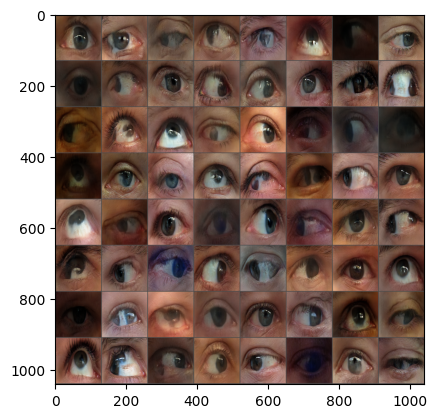

In [ ]:
# get generated class-wise samples from latest checkpoint
import os
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

# ===============================================
# CONFIG
# ===============================================
ROOT_DIR = "MOBIUS/Images"
SAVE_DIR = "Images/cDCGAN/results"
os.makedirs(SAVE_DIR, exist_ok=True)

IMG_SIZE = 256
NUM_CLASSES = 100
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ===============================================
# TRANSFORM (same as training)
# ===============================================
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=Image.LANCZOS),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

inv_normalize = transforms.Normalize(
    mean=[-1, -1, -1],
    std=[2, 2, 2]
)

# ===============================================
# LOAD cDCGAN GENERATOR
# ===============================================
z_dim = 100
G = Generator(z_dim=z_dim, num_classes=NUM_CLASSES, img_channels=3).to(DEVICE)

ckpt = torch.load("savedModels/cDCGAN_MOBIUS/latest_checkpoint.pth", map_location=DEVICE)
G.load_state_dict(ckpt["generator_state_dict"])
G.eval()

print("✅ Loaded Generator Checkpoint")


# ===============================================
# HELPER — Load 8 REAL images for a class
# ===============================================
def load_real_images(class_id, n=8):
    class_path = os.path.join(ROOT_DIR, str(class_id))
    files = [os.path.join(class_path, f) for f in os.listdir(class_path)
             if f.lower().endswith((".png", ".jpg", ".jpeg")) and "_bad" not in f.lower()]

    files = sorted(files)[:n]  # take first 8 consistent images

    imgs = []
    for f in files:
        img = Image.open(f).convert("RGB")
        img = transform(img)
        imgs.append(img)

    return torch.stack(imgs)  # shape: (8, 3, H, W)


# ===============================================
# HELPER — Generate 8 FAKE images for a class
# ===============================================
def generate_fake_images(class_id, n=8):
    z = torch.randn(n, z_dim, device=DEVICE)
    labels = torch.full((n,), class_id, dtype=torch.long, device=DEVICE)
    fake = G(z, labels).detach().cpu()

    return fake


# ===============================================
# HELPER — Plot real (left) & fake (right)
# ===============================================
def save_plot(real_imgs, fake_imgs, class_id):
    real_imgs = inv_normalize(real_imgs)
    fake_imgs = inv_normalize(fake_imgs)

    fig, axs = plt.subplots(2, 8, figsize=(20, 6))
    fig.suptitle(f"Class {class_id} — Real (Top) vs Fake (Bottom)", fontsize=18)

    # Real
    for i in range(8):
        axs[0, i].imshow(real_imgs[i].permute(1, 2, 0).clamp(0,1).numpy())
        axs[0, i].axis("off")

    # Fake
    for i in range(8):
        axs[1, i].imshow(fake_imgs[i].permute(1, 2, 0).clamp(0,1).numpy())
        axs[1, i].axis("off")

    save_path = os.path.join(SAVE_DIR, f"class_{class_id}.png")
    plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.close()

    print(f"Saved → {save_path}")


# ===============================================
# MAIN LOOP — Generate 100 plots
# ===============================================
for class_id in tqdm(range(NUM_CLASSES), desc="Generating Plots"):
    real_imgs = load_real_images(class_id)
    fake_imgs = generate_fake_images(class_id)

    save_plot(real_imgs, fake_imgs, class_id)

print("\n🎉 All 100 plots generated successfully!")


## Diffusion Model

## UNet-Lite Model
- 3-level Unet, 64 base channels

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import utils
from tqdm import tqdm
import math, os
import matplotlib.pyplot as plt
from torchmetrics.image.fid import FrechetInceptionDistance

In [6]:
# ============================
# DATALOADER
# ============================
dataset = MOBIUSDataset(DATASET_ROOT, transform=transform, filter_bad=FILTER_BAD)

dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

# quick check
imgs = next(iter(dataloader))
print(f"Batch shape: {imgs.shape}")

✅ Loaded 14331 clean images from MOBIUS/Images
Batch shape: torch.Size([16, 3, 128, 128])


In [7]:
# Cosine Beta schedule
def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi / 2) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)


timesteps = 200  # fewer steps = faster
betas = cosine_beta_schedule(timesteps)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

betas = betas.to(device)
alphas = alphas.to(device)
alphas_cumprod = alphas_cumprod.to(device)
sqrt_alphas_cumprod = sqrt_alphas_cumprod.to(device)
sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod.to(device)


def forward_diffusion_sample(x_0, t, device):
    noise = torch.randn_like(x_0)
    sqrt_a = sqrt_alphas_cumprod[t].to(device).reshape(-1, 1, 1, 1)
    sqrt_1_m_a = sqrt_one_minus_alphas_cumprod[t].to(device).reshape(-1, 1, 1, 1)
    return sqrt_a * x_0 + sqrt_1_m_a * noise, noise

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, t_emb_dim, dropout=0.1):
        super().__init__()
        groups = 8 if out_ch % 8 == 0 else 1

        self.time_mlp = nn.Sequential(
            nn.Linear(t_emb_dim, out_ch),
            nn.SiLU(),
        )
        self.block1 = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(groups, out_ch),
            nn.SiLU(),
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.GroupNorm(groups, out_ch),
            nn.SiLU(),
            nn.Dropout(dropout),
        )
        self.res_conv = (
            nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
        )

    def forward(self, x, t):
        t_out = self.time_mlp(t).unsqueeze(-1).unsqueeze(-1)
        h = self.block1(x)
        h = h + t_out
        h = self.block2(h)
        return h + self.res_conv(x)


class UNetLite(nn.Module):
    def __init__(self, img_channels=3, base_ch=64, t_emb_dim=256):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.Linear(1, t_emb_dim),
            nn.SiLU(),
            nn.Linear(t_emb_dim, t_emb_dim),
        )

        self.enc1 = ResidualBlock(img_channels, base_ch, t_emb_dim)
        self.enc2 = ResidualBlock(base_ch, base_ch * 2, t_emb_dim)
        self.enc3 = ResidualBlock(base_ch * 2, base_ch * 4, t_emb_dim)

        self.middle = ResidualBlock(base_ch * 4, base_ch * 4, t_emb_dim)

        self.dec3 = ResidualBlock(base_ch * 4 + base_ch * 4, base_ch * 2, t_emb_dim)
        self.dec2 = ResidualBlock(base_ch * 2 + base_ch * 2, base_ch, t_emb_dim)
        self.dec1 = ResidualBlock(base_ch + base_ch, img_channels, t_emb_dim)

        self.down = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode="nearest")

    def forward(self, x, t):
        t_emb = self.time_mlp(t)

        x1 = self.enc1(x, t_emb)
        x2 = self.enc2(self.down(x1), t_emb)
        x3 = self.enc3(self.down(x2), t_emb)

        m = self.middle(self.down(x3), t_emb)

        d3 = self.up(m)
        d3 = self.dec3(torch.cat([d3, x3], dim=1), t_emb)
        d2 = self.up(d3)
        d2 = self.dec2(torch.cat([d2, x2], dim=1), t_emb)
        d1 = self.up(d2)
        out = self.dec1(torch.cat([d1, x1], dim=1), t_emb)
        return out

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = UNetLite(img_channels=3, base_ch=64, t_emb_dim=128).to(device)
optimizer = optim.AdamW(model.parameters(), lr=2e-4)
scaler = torch.cuda.amp.GradScaler()
fid = FrechetInceptionDistance(feature=2048).to(device)

checkpoint_path = "savedModels/DDPM_MOBIUS/latest_checkpoint.pth"
if os.path.exists(checkpoint_path):
    print("Loading checkpoint...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    best_fid = checkpoint.get("fid", float("inf"))
    print(
        f"Resumed from checkpoint with best FID: {best_fid:.4f} & epoch {checkpoint['epoch']}"
    )

epochs = 18
fixed_noise = torch.randn(16, 3, 128, 128, device=device)
best_fid = float("inf")

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for batch in tqdm(dataloader):
        if isinstance(batch, (list, tuple)):
            x_real = batch[0].to(device)
        else:
            x_real = batch.to(device)

        t = torch.randint(0, timesteps, (x_real.size(0),), device=device).long()

        with torch.cuda.amp.autocast():
            x_noisy, noise = forward_diffusion_sample(x_real, t, device)
            noise_pred = model(x_noisy, t.unsqueeze(-1).float())
            loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] | Loss={epoch_loss/len(dataloader):.4f}")

    # # ----- FID every 5 epochs -----
    # if (epoch + 1) % 5 == 0:
    #     model.eval()
    #     fid.reset()
    #     with torch.no_grad():
    #         for real_batch in dataloader:
    #             real_uint8 = preprocess_for_fid(real_batch.to(device))
    #             fid.update(real_uint8, real=True)

    #         for _ in range(len(dataloader)):
    #             t = torch.randint(0, timesteps, (real_batch.size(0),), device=device)
    #             noise = torch.randn_like(real_batch).to(device)
    #             fake = noise
    #             for i in reversed(range(timesteps)):
    #                 t_batch = torch.full(
    #                     (real_batch.size(0),), i, device=device, dtype=torch.long
    #                 )
    #                 betas_t = betas[t_batch].to(device)
    #                 sqrt_1m_acp_t = sqrt_one_minus_alphas_cumprod[t_batch].to(device)
    #                 sqrt_recip_a_t = (1.0 / torch.sqrt(alphas[t_batch])).to(device)
    #                 pred = model(fake, t_batch.unsqueeze(-1).float())
    #                 mean = sqrt_recip_a_t * (fake - betas_t / sqrt_1m_acp_t * pred)
    #                 if i > 0:
    #                     noise = torch.randn_like(fake)
    #                     fake = mean + torch.sqrt(betas_t) * noise
    #                 else:
    #                     fake = mean

    #             fake_uint8 = preprocess_for_fid(fake)
    #             fid.update(fake_uint8, real=False)

    #     fid_score = fid.compute().item()
    #     print(f"FID at epoch {epoch+1}: {fid_score:.4f}")

    #     if fid_score < best_fid:
    #         best_fid = fid_score
    #         torch.save(
    #             {
    #                 "epoch": epoch,
    #                 "model_state_dict": model.state_dict(),
    #                 "optimizer_state_dict": optimizer.state_dict(),
    #                 "fid": best_fid,
    #             },
    #             "savedModels/DDPM_MOBIUS_best.pth",
    #         )
    #         print(f"✅ New best FID {best_fid:.4f}, checkpoint saved.")

Loading checkpoint...
Resumed from checkpoint with best FID: inf & epoch 57


  1%|▉                                                                                 | 10/896 [00:30<45:10,  3.06s/it]


KeyboardInterrupt: 

In [15]:
model = UNetLite(img_channels=3, base_ch=64, t_emb_dim=128).to(device)
optimizer = optim.AdamW(model.parameters(), lr=2e-4)
fid = FrechetInceptionDistance(feature=2048).to(device)

checkpoint = torch.load(
    "savedModels/DDPM_MOBIUS/latest_checkpoint.pth", map_location=device
)

if checkpoint:
    print("Loading checkpoint for FID evaluation...")
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    best_fid = checkpoint.get("fid", float("inf"))
model.eval()
fid.reset()

with torch.no_grad():
    # --- Real images ---
    for real_batch in dataloader:
        real_uint8 = preprocess_for_fid(real_batch.to(device))
        fid.update(real_uint8, real=True)

    # --- Fake images ---
    batch_size = dataloader.batch_size

    for _ in range(len(dataloader)):
        fake = torch.randn(batch_size, 3, 128, 128, device=device)  # Start from noise

        for i in reversed(range(timesteps)):
            t_batch = torch.full((batch_size,), i, device=device, dtype=torch.long)
            betas_t = betas[t_batch]
            sqrt_1m_acp_t = sqrt_one_minus_alphas_cumprod[t_batch]
            sqrt_recip_a_t = 1.0 / torch.sqrt(alphas[t_batch])

            pred = model(fake, t_batch.unsqueeze(-1).float())

            mean = sqrt_recip_a_t[:, None, None, None] * (
                fake
                - betas_t[:, None, None, None]
                / sqrt_1m_acp_t[:, None, None, None]
                * pred
            )

            if i > 0:
                noise = torch.randn_like(fake)
                fake = mean + torch.sqrt(betas_t)[:, None, None, None] * noise
            else:
                fake = mean

        fake_uint8 = preprocess_for_fid(fake)
        fid.update(fake_uint8, real=False)

# --- Compute FID ---
fid_score = fid.compute().item()
print(f"FID at epoch {epoch+1}: {fid_score:.4f}")

# --- Checkpoint Saving ---
if fid_score < best_fid:
    best_fid = fid_score
    torch.save(
        {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "fid": best_fid,
        },
        "savedModels/DDPM_MOBIUS_best.pth",
    )
    print(f"✅ New best FID {best_fid:.4f}, checkpoint saved!")

Loading checkpoint for FID evaluation...


KeyboardInterrupt: 

In [32]:
torch.save(
    {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "fid": float("inf"),
    },
    "savedModels/DDPM_MOBIUS/latest_checkpoint.pth",
)

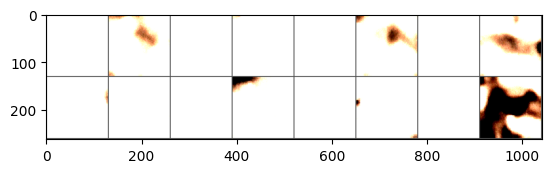

In [16]:
# get generated samples from latest checkpoint of diffusion model
import torch
import torch.nn.functional as F
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


@torch.no_grad()
def sample_images(model, n=16, img_size=128, timesteps=100, device="cuda"):
    model.eval()

    # Start from pure noise
    x = torch.randn(n, 3, img_size, img_size, device=device)

    # Reverse diffusion process
    for i in reversed(range(timesteps)):
        t = torch.full((n,), i, device=device, dtype=torch.long)

        # Get coefficients for this timestep and reshape for broadcasting
        betas_t = betas[t][:, None, None, None].to(device)
        sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t][
            :, None, None, None
        ].to(device)
        sqrt_recip_alphas_t = (1.0 / torch.sqrt(alphas[t]))[:, None, None, None].to(
            device
        )

        # Predict noise and compute mean
        noise_pred = model(x, t.unsqueeze(-1).float())
        model_mean = sqrt_recip_alphas_t * (
            x - betas_t / sqrt_one_minus_alphas_cumprod_t * noise_pred
        )

        if i > 0:
            noise = torch.randn_like(x)
            beta_t = betas_t
            x = model_mean + torch.sqrt(beta_t) * noise
        else:
            x = model_mean

    # Map from [-1,1] -> [0,1]
    x = (x.clamp(-1, 1) + 1) / 2
    return x


device = "cuda" if torch.cuda.is_available() else "cpu"

z_dim = 100
model = UNetLite(img_channels=3, base_ch=64, t_emb_dim=128).to(device)
optimizer = optim.AdamW(model.parameters(), lr=2e-4)

checkpoint = torch.load(
    "savedModels/DDPM_MOBIUS/latest_checkpoint.pth", map_location=device
)
if checkpoint:
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

generated_samples = sample_images(model, img_size=128, n=16, timesteps=200)
show_imgs(generated_samples)